## Model Metrics Analysis 
---------
*This notebook works best with the conda_python3 kernel on a ml.t3.medium machine*.

### This part of our solution design includes the chunk of taking the metrics generated and creating visualizations from it for further analysis to make decisions more quicker, efficient, and cost optimal.

- In this file, we will go over and create side by side visualizations of different models deployed, how their inference latency is impacted based on the concurrency level, instance size and different model configurations. Using these visualizations and charts, making executive decisions, saving on time and cost becomes critical. 


- In this notebook, we will also record the error rates for each of the deployed model endpoints based on how it ran against different metrics as specified above. These visualizations will be applicable and work for any and every jumpstart and non jumpstart model if deployed correctly using the prior steps.

#### Import all of the necessary libraries below to run this notebook

In [1]:
# if interactive mode is set to no -> pickup fmbench from Python installation path
# if interactive mode is set to yes -> pickup fmbench from the current path (one level above this notebook)
# if interactive mode is not defined -> pickup fmbench from the current path (one level above this notebook)
# the premise is that if run non-interactively then it can only be run through main.py which will set interactive mode to no
import os
import sys
if os.environ.get("INTERACTIVE_MODE_SET", "yes") == "yes":
    sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import io
import math
import json
import tempfile
import datetime
import matplotlib
import numpy as np
import pandas as pd

# Import seaborn and other related libraries for visualizations and plotting charts
import seaborn as sns
from pathlib import Path
from tomark import Tomark
from fmbench.utils import *
from fmbench.globals import *
from datetime import datetime
from datetime import timezone
from dateutil.parser import parse
from typing import List, Optional, Dict
import importlib.resources as pkg_resources

config file current -> configs/config-llama2-13b-inf2-g5-p4d.yml, None
loaded config: {'general': {'name': 'llama2-13b-inf2-g5-p4d-v2', 'model_name': 'Llama2-13b'}, 'aws': {'region': 'us-east-1', 'sagemaker_execution_role': 'arn:aws:sts::015469603702:assumed-role/fmbench-role/SageMaker', 'bucket': 'sagemaker-fmbench-write-us-east-1-015469603702'}, 'dir_paths': {'data_prefix': 'data', 'prompts_prefix': 'prompts', 'all_prompts_file': 'all_prompts.csv', 'metrics_dir': 'metrics', 'models_dir': 'models', 'metadata_dir': 'metadata'}, 's3_read_data': {'read_bucket': 'sagemaker-fmbench-read-us-east-1-015469603702', 'scripts_prefix': 'scripts', 'script_files': ['hf_token.txt'], 'configs_prefix': 'configs', 'config_files': ['pricing.yml'], 'source_data_prefix': 'source_data', 'source_data_files': ['2wikimqa_e.jsonl', '2wikimqa.jsonl', 'hotpotqa_e.jsonl', 'hotpotqa.jsonl', 'narrativeqa.jsonl', 'triviaqa_e.jsonl', 'triviaqa.jsonl'], 'tokenizer_prefix': 'tokenizer', 'prompt_template_dir': 'prompt_t

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [3]:
# for plotting
import matplotlib.pyplot as plt
# rcParams for configuring Matplotlib settings
from matplotlib import rcParams
import plotly
import plotly.io as pio
import plotly.express as px

# figure size in inches
rcParams['figure.figsize'] = 10, 6

In [4]:
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

Load the Config.yml file contains information that is used across this benchmarking environment, such as information about the aws account, prompts, payloads to be used for invocations

In [5]:
logger.info(f"CONFIG_FILE={CONFIG_FILE}")
config = load_main_config(CONFIG_FILE)
logger.info(json.dumps(config, indent=2))

[2024-05-05 22:13:40,329] p21340 {2445076252.py:1} INFO - CONFIG_FILE=configs/config-llama2-13b-inf2-g5-p4d.yml
[2024-05-05 22:13:40,417] p21340 {2445076252.py:3} INFO - {
  "general": {
    "name": "llama2-13b-inf2-g5-p4d-v2",
    "model_name": "Llama2-13b"
  },
  "aws": {
    "region": "us-east-1",
    "sagemaker_execution_role": "arn:aws:sts::015469603702:assumed-role/fmbench-role/SageMaker",
    "bucket": "sagemaker-fmbench-write-us-east-1-015469603702"
  },
  "dir_paths": {
    "data_prefix": "data",
    "prompts_prefix": "prompts",
    "all_prompts_file": "all_prompts.csv",
    "metrics_dir": "metrics",
    "models_dir": "models",
    "metadata_dir": "metadata"
  },
  "s3_read_data": {
    "read_bucket": "sagemaker-fmbench-read-us-east-1-015469603702",
    "scripts_prefix": "scripts",
    "script_files": [
      "hf_token.txt"
    ],
    "configs_prefix": "configs",
    "config_files": [
      "pricing.yml"
    ],
    "source_data_prefix": "source_data",
    "source_data_files": 

#### Load the associated pricing config file

In [6]:
# represents getting the config file from the s3 bucket/https path for pricing yml information
pricing_file_path: str = config['pricing'] 

# initialize the pricing config file to None
pricing_config: Optional[Dict] = None

# get the current config dir path
config_dir = Path(pkg_resources.files('fmbench'), 'configs')
logger.info(f"Using fmbench.configs directory: {config_dir}")

pricing_module = Path(config['pricing'])
logger.info(f"pricing config provided for inference from this model is --> {pricing_module}")
pricing_file_path = os.path.join(config_dir, pricing_module)
logger.info(f"pricing config file path is --> {pricing_file_path}")

pricing_config = load_config(pricing_file_path)
logger.info(f"pricing config file recorded: {json.dumps(pricing_config, indent=2)}")

[2024-05-05 22:13:40,425] p21340 {2131877439.py:9} INFO - Using fmbench.configs directory: /home/ec2-user/anaconda3/envs/fmbench_python311/lib/python3.11/site-packages/fmbench/configs
[2024-05-05 22:13:40,428] p21340 {2131877439.py:12} INFO - pricing config provided for inference from this model is --> pricing.yml
[2024-05-05 22:13:40,429] p21340 {2131877439.py:14} INFO - pricing config file path is --> /home/ec2-user/anaconda3/envs/fmbench_python311/lib/python3.11/site-packages/fmbench/configs/pricing.yml
[2024-05-05 22:13:40,493] p21340 {2131877439.py:17} INFO - pricing config file recorded: {
  "pricing": {
    "instance_based": {
      "ml.m5.xlarge": 0.23,
      "ml.g5.xlarge": 1.006,
      "ml.g5.2xlarge": 1.212,
      "ml.g5.12xlarge": 7.09,
      "ml.g5.24xlarge": 10.18,
      "ml.g5.48xlarge": 20.36,
      "ml.inf2.xlarge": 0.7582,
      "ml.inf2.8xlarge": 1.968,
      "ml.inf2.24xlarge": 6.491,
      "ml.inf2.48xlarge": 12.981,
      "ml.p4d.24xlarge": 37.688,
      "ml.p5.48

In [7]:
debug = False
if debug is True:
    metrics_path_file: str = os.path.join("..", "..", METADATA_DIR, METRICS_PATH_FNAME)
else:
    metrics_path_file: str = os.path.join(METADATA_DIR, METRICS_PATH_FNAME)
logger.info(f"cwd={os.getcwd()}, METADATA_DIR={METADATA_DIR}, METRICS_PATH_FNAME={METRICS_PATH_FNAME}, metrics_path_file={metrics_path_file}")
METRICS_DIR: str = Path(metrics_path_file).read_text().strip()
logger.info(f"metrics_path_file={metrics_path_file}, METRICS_DIR={METRICS_DIR}")

[2024-05-05 22:13:40,506] p21340 {1795854198.py:6} INFO - cwd=/home/ec2-user/SageMaker/repos_latest_today/foundation-model-benchmarking-tool/src/fmbench, METADATA_DIR=metadata, METRICS_PATH_FNAME=metrics_path.txt, metrics_path_file=../../metadata/metrics_path.txt
[2024-05-05 22:13:40,515] p21340 {1795854198.py:8} INFO - metrics_path_file=../../metadata/metrics_path.txt, METRICS_DIR=llama2-13b-inf2-g5-p4d-v2-SageMaker/data/metrics/yyyy=2024/mm=05/dd=05/hh=19/mm=28


In [8]:
file_path = os.path.join(METRICS_DIR, config["report"]["per_inference_request_file"])
logger.info(f"File path containing the metrics per inference folder --> {file_path}")

# Read the file from S3
try:
    file_content = get_s3_object(config['aws']['bucket'], file_path)
    # Use pandas to read the CSV content
    df_per_inference = pd.read_csv(io.StringIO(file_content))
    logger.info(f"{file_path} read into dataframe of shape {df_per_inference.shape}")
    df_per_inference.head()
except Exception as e:
    logger.error(f"Error reading from S3: {e}")

df_per_inference.head()

[2024-05-05 22:13:40,533] p21340 {2220891072.py:2} INFO - File path containing the metrics per inference folder --> llama2-13b-inf2-g5-p4d-v2-SageMaker/data/metrics/yyyy=2024/mm=05/dd=05/hh=19/mm=28/per_inference_request_results.csv
[2024-05-05 22:13:41,556] p21340 {2220891072.py:9} INFO - llama2-13b-inf2-g5-p4d-v2-SageMaker/data/metrics/yyyy=2024/mm=05/dd=05/hh=19/mm=28/per_inference_request_results.csv read into dataframe of shape (3162, 40)


,endpoint_name,prompt,temperature,do_sample,top_p,top_k,max_new_tokens,return_full_text,completion,prompt_tokens,...,HUGGING_FACE_HUB_TOKEN,MAX_BATCH_TOTAL_TOKENS,MAX_INPUT_LENGTH,MAX_TOTAL_TOKENS,SAGEMAKER_CONTAINER_LOG_LEVEL,SAGEMAKER_REGION,SM_NUM_GPUS,ENDPOINT_SERVER_TIMEOUT,MODEL_CACHE_ROOT,SAGEMAKER_ENV
0,llama-2-13b-inf2-24xlarge-1714935213-0188894,<s>[INST] <<SYS>>\nYou are an assistant for qu...,0.1,True,0.92,120,100,False,Both Sinofranchetia and Stauntonia are from th...,304,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,llama-2-13b-inf2-24xlarge-1714935213-0188894,<s>[INST] <<SYS>>\nYou are an assistant for qu...,0.1,True,0.92,120,100,False,Both WAGS Atlanta and WAGS are reality televis...,980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,llama-2-13b-inf2-24xlarge-1714935213-0188894,<s>[INST] <<SYS>>\nYou are an assistant for qu...,0.1,True,0.92,120,100,False,"No, I don't think so. Rhosgoch is located in W...",1339,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,llama-2-13b-inf2-24xlarge-1714935213-0188894,<s>[INST] <<SYS>>\nYou are an assistant for qu...,0.1,True,0.92,120,100,False,Based on the information provided in the given...,1932,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,llama-2-13b-inf2-24xlarge-1714935213-0188894,<s>[INST] <<SYS>>\nYou are an assistant for qu...,0.1,True,0.92,120,100,False,"Yes, both Gut (Crișul Alb) and Gepiș are locat...",1154,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Relationship between prompt token length and inference latency for different instances and concurrency levels

[2024-05-05 22:13:41,619] p21340 {1420996857.py:3} INFO - df_per_inference.latency.quantile ->
0.25     1.938482
0.50     3.531862
0.75     6.197850
0.95    11.213800
0.99    16.127229
Name: latency, dtype: float64
[2024-05-05 22:13:45,970] p21340 {1420996857.py:63} INFO - yticks is configured, yticks=[0, 5, 10, 15, 20, 25, 30, 35]
[2024-05-05 22:13:49,164] p21340 {1420996857.py:76} INFO - Plot saved to s3://sagemaker-fmbench-write-us-east-1-015469603702/llama2-13b-inf2-g5-p4d-v2-SageMaker/data/metrics/yyyy=2024/mm=05/dd=05/hh=19/mm=28/tokens_vs_latency.png


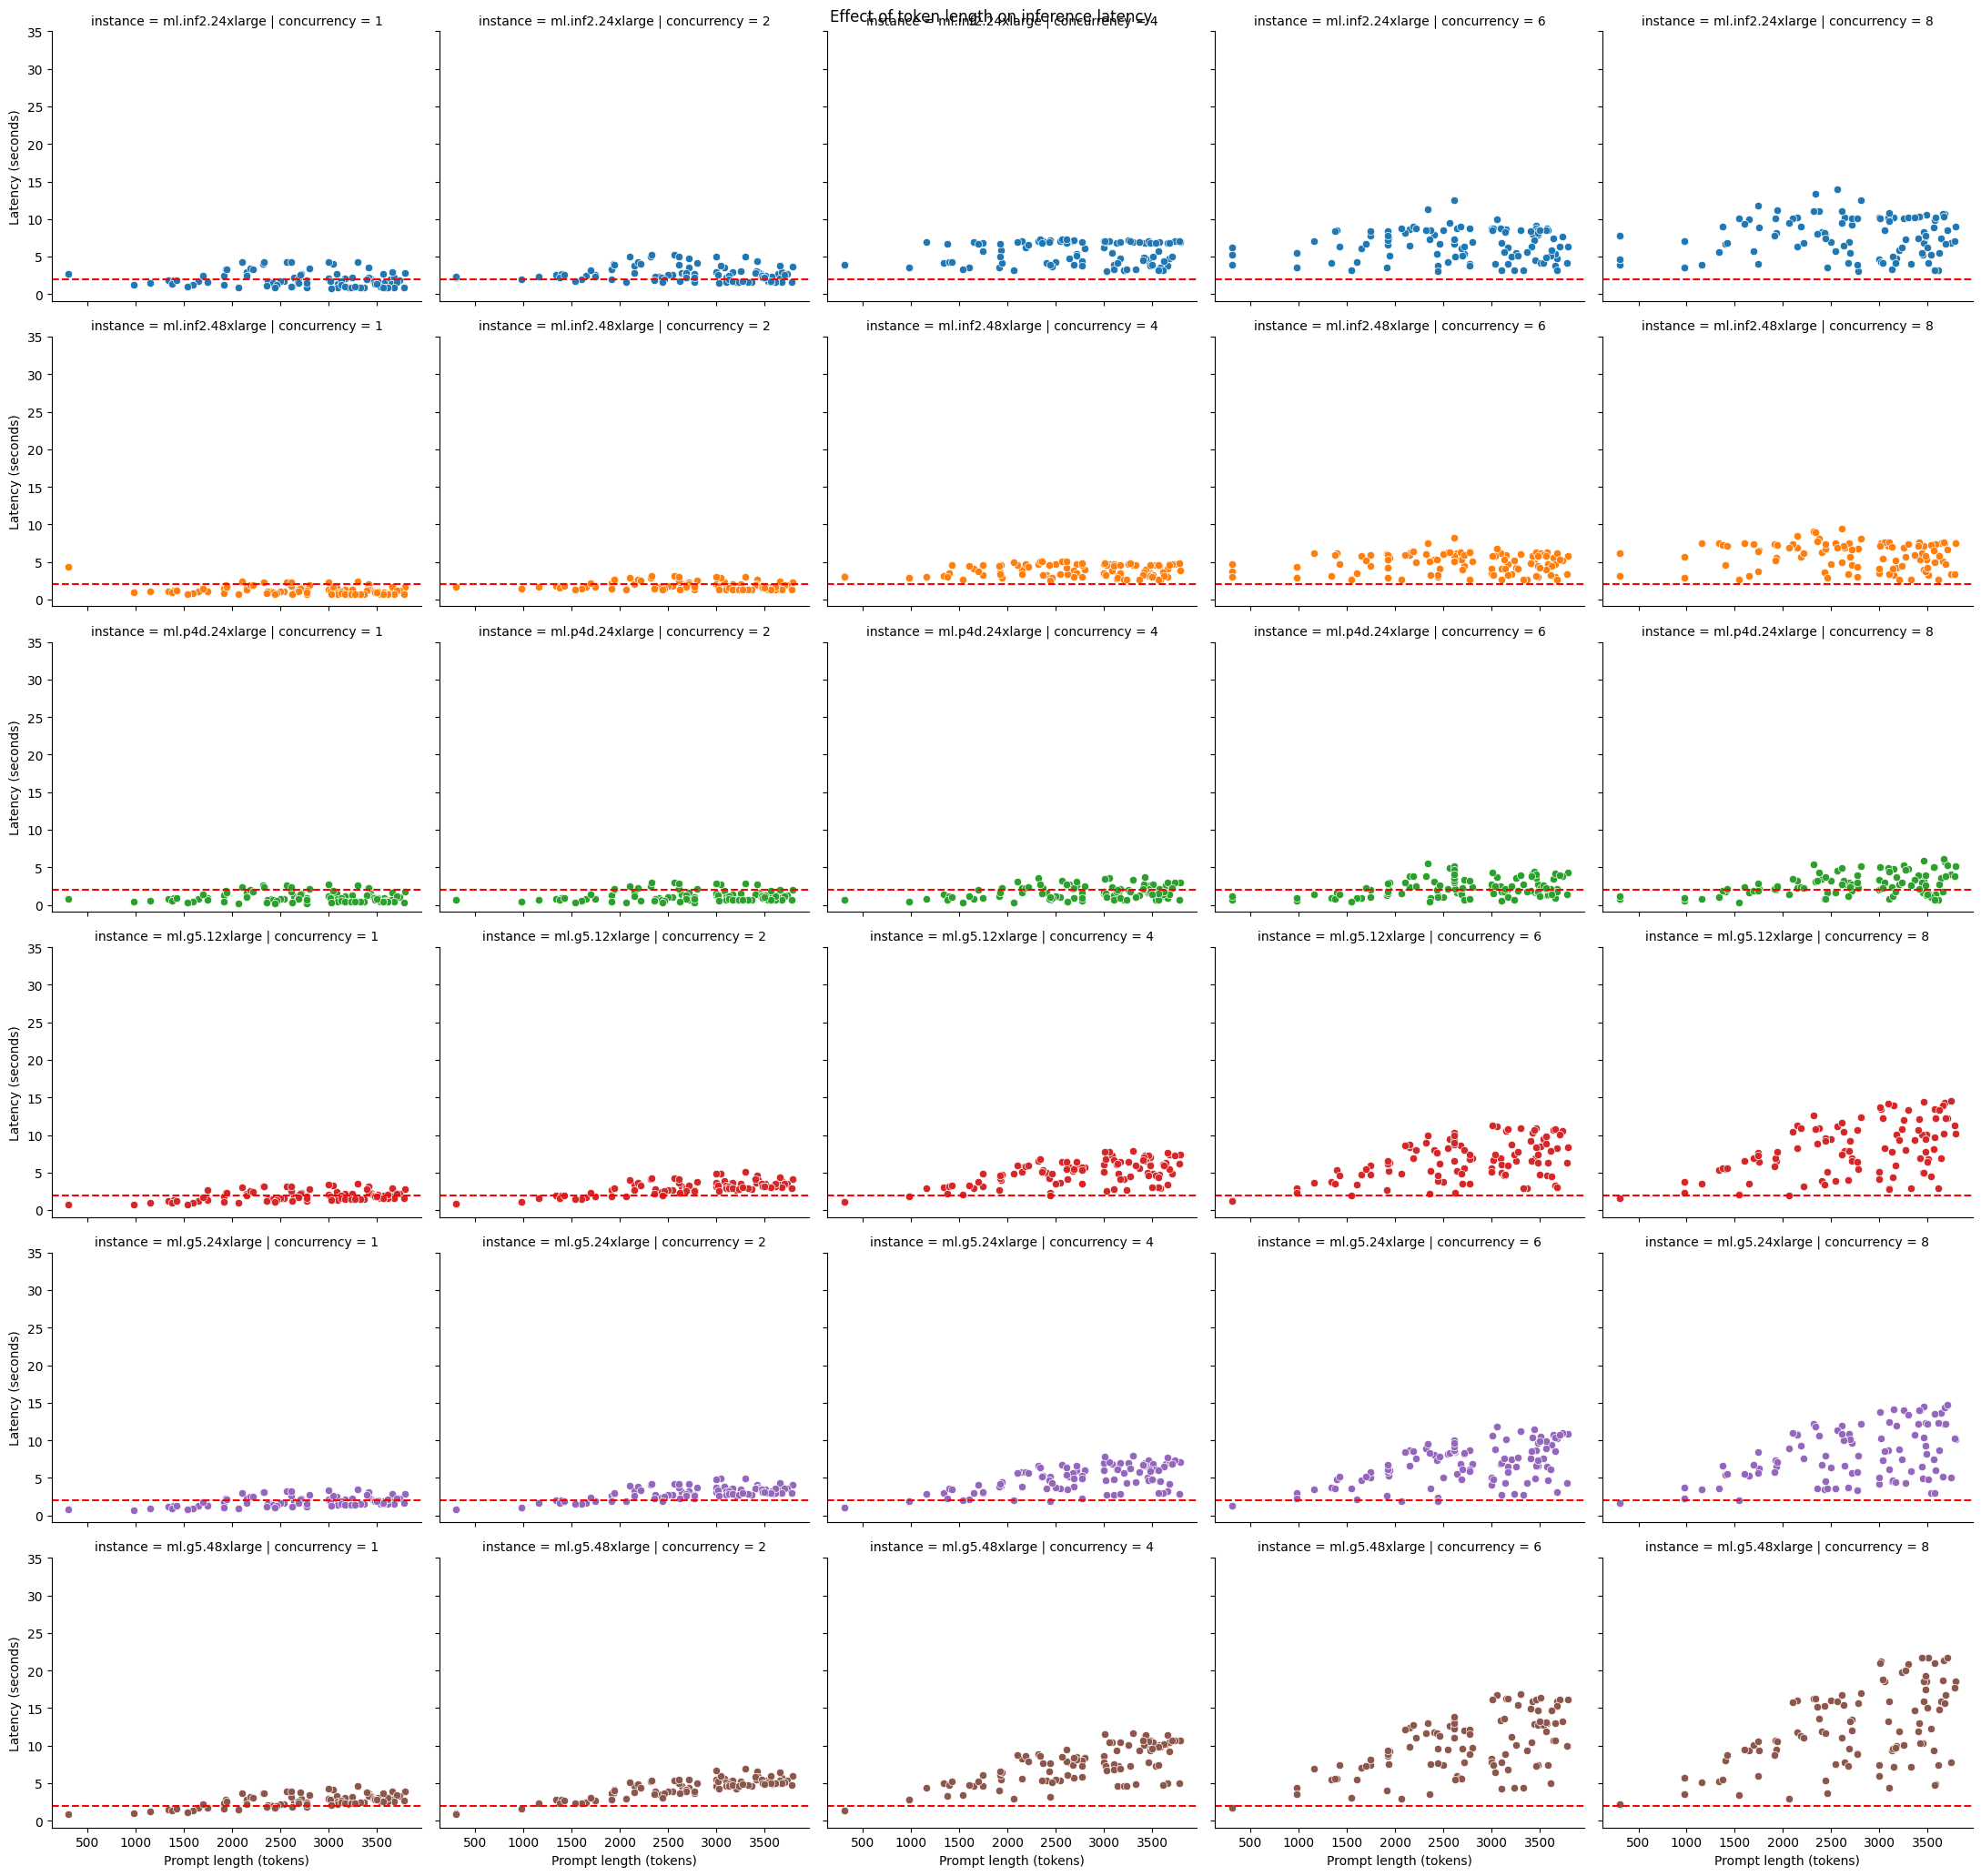

In [9]:
# Rename a column in the dataframe for clarity of the instance parameter of the model used
df_per_inference = df_per_inference.rename(columns={"instance_type": "instance"})
logger.info(f"df_per_inference.latency.quantile ->\n{df_per_inference.latency.quantile([0.25, 0.5, 0.75, 0.95, 0.99])}")
if df_per_inference.latency.quantile(0.5) < 1:
    print("multiplying by 1000")
    latency_units = "milliseconds"
    multiplier = 1000
    step_size = 500
    df_per_inference.latency = df_per_inference.latency*1000
else:
    multiplier = 10
    step_size = 5
    latency_units = "seconds"

## Initializing yticks and title for the chart
yticks: Optional[List] = None
title: Optional[str] = None

if config['report'].get('latency_vs_token_len_chart'):
    yticks: List = config['report']['latency_vs_token_len_chart'].get('y_ticks')
    title: str = config['report']['latency_vs_token_len_chart'].get('title')

if title is None:
    title = "Effect of token length on inference latency"

if len(df_per_inference.instance.unique()) == 1:
    # This created a FacetGrid for plotting multiple scatter plots based on 'instance' and 'concurrency' categories
    g = sns.FacetGrid(df_per_inference, col="concurrency", hue="instance", height=3.5, aspect=1.25, col_wrap=3)
else: 
    g = sns.FacetGrid(df_per_inference, col="concurrency", row="instance", hue="instance", height=3.5, aspect=1.25)


## Subtitle of the facetgrid
g.fig.suptitle(title)
# # This will map a scatterplot to the FacetGrid for each subset of the data
sns_plot = g.map(sns.scatterplot, "prompt_tokens", "latency")

# flatten axes into a 1-d array
axes = g.axes.flatten()

# iterate through the axes
for i, ax in enumerate(axes):
    if latency_units == "milliseconds":
        m = 1000
    else:
        m = 1
    ax.axhline(config['report']['latency_budget']*m, ls='--', c='red')

# Set the y-axis label for all plots
g = g.set_ylabels(f"Latency ({latency_units})")
    
if yticks is None:
    # Y-axis ticks based on the maximum latency value and setting them in that manner
    yticks: List = list(range(0, (int(df_per_inference.latency.max())//multiplier+2)*multiplier, step_size))

if yticks is None:
    # Y-axis ticks based on the maximum latency value and setting them in that manner
    yticks: List = list(range(0, (int(df_per_inference.latency.max())//multiplier+1)*multiplier, step_size))
    logger.info(f"yticks was not configured, setting it to yticks[:10]={yticks[:10]}, "
                f"based on latency max of {df_per_inference.latency.max()}s, "
                f"multiplier={multiplier}, step_size={step_size}")
else:
    logger.info(f"yticks is configured, yticks={yticks}")
g = g.set(yticks=yticks)

# Set the x-axis label for all plots as the prompt length or tokens
g = g.set_xlabels("Prompt length (tokens)")

# Create a bytes buffer to save the plot
buffer = io.BytesIO()
sns_plot.savefig(buffer, format='png')
buffer.seek(0)  # Rewind buffer to the beginning

# Write the plot to S3
write_to_s3(buffer.getvalue(), BUCKET_NAME, "", METRICS_DIR, TOKENS_VS_LATENCY_PLOT_FNAME)
logger.info(f"Plot saved to s3://{BUCKET_NAME}/{METRICS_DIR}/{TOKENS_VS_LATENCY_PLOT_FNAME}")

# Optionally, display the plot
sns_plot

In [10]:
df_per_inference.latency.describe()

count    3162.000000
mean        4.537329
std         3.459116
min         0.174567
25%         1.938482
50%         3.531862
75%         6.197850
max        21.697943
Name: latency, dtype: float64

#### Define the all metrics file path and read it to generate visualizations

In [11]:
all_metrics_fpath = os.path.join(METRICS_DIR, config["report"]["all_metrics_file"])

# Read the file from S3
try:
    logger.info(f"going to read all metrics file from {all_metrics_fpath}")
    file_content = get_s3_object(BUCKET_NAME, all_metrics_fpath)
    
    # Use pandas to read the CSV content
    df_all_metrics = pd.read_csv(io.StringIO(file_content))
    logger.info(f"{all_metrics_fpath} read into dataframe of shape {df_all_metrics.shape}")
    df_all_metrics.head()
except Exception as e:
    logger.error(f"Error reading from S3: {e}")

df_all_metrics.head()

[2024-05-05 22:13:53,093] p21340 {891887541.py:5} INFO - going to read all metrics file from llama2-13b-inf2-g5-p4d-v2-SageMaker/data/metrics/yyyy=2024/mm=05/dd=05/hh=19/mm=28/all_metrics.csv
[2024-05-05 22:13:53,259] p21340 {891887541.py:10} INFO - llama2-13b-inf2-g5-p4d-v2-SageMaker/data/metrics/yyyy=2024/mm=05/dd=05/hh=19/mm=28/all_metrics.csv read into dataframe of shape (1236, 45)


,experiment_name,concurrency,payload_file,errors,successes,error_rate,all_prompts_token_count,prompt_token_count_mean,prompt_token_throughput,all_completions_token_count,...,HUGGING_FACE_HUB_TOKEN,MAX_BATCH_TOTAL_TOKENS,MAX_INPUT_LENGTH,MAX_TOTAL_TOKENS,SAGEMAKER_CONTAINER_LOG_LEVEL,SAGEMAKER_REGION,SM_NUM_GPUS,ENDPOINT_SERVER_TIMEOUT,MODEL_CACHE_ROOT,SAGEMAKER_ENV
0,llama2-13b-inf2.24xlarge-djl-0.24.0-neuronx-sd...,1,payload_en_1-500.jsonl,[],1,0.0,304,304.0,112.38,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,llama2-13b-inf2.24xlarge-djl-0.24.0-neuronx-sd...,1,payload_en_500-1000.jsonl,[],1,0.0,980,980.0,785.62,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,llama2-13b-inf2.24xlarge-djl-0.24.0-neuronx-sd...,1,payload_en_1000-2000.jsonl,[],1,0.0,1339,1339.0,716.78,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,llama2-13b-inf2.24xlarge-djl-0.24.0-neuronx-sd...,1,payload_en_1000-2000.jsonl,[],1,0.0,1932,1932.0,590.81,72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,llama2-13b-inf2.24xlarge-djl-0.24.0-neuronx-sd...,1,payload_en_1000-2000.jsonl,[],1,0.0,1154,1154.0,754.16,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
## displaying all of the available columns in the all metrics dataframe
df_all_metrics.columns

Index(['experiment_name', 'concurrency', 'payload_file', 'errors', 'successes',
       'error_rate', 'all_prompts_token_count', 'prompt_token_count_mean',
       'prompt_token_throughput', 'all_completions_token_count',
       'completion_token_count_mean', 'completion_token_throughput',
       'transactions', 'transactions_per_second', 'transactions_per_minute',
       'latency_mean', 'latency_p50', 'latency_p95', 'latency_p99',
       'instance_type', 'EndpointName', 'ModelName', 'Image', 'S3Uri',
       'OPTION_DTYPE', 'OPTION_MAX_ROLLING_BATCH_SIZE',
       'OPTION_NEURON_OPTIMIZE_LEVEL', 'OPTION_N_POSITIONS',
       'OPTION_ROLLING_BATCH', 'OPTION_TENSOR_PARALLEL_DEGREE',
       'SAGEMAKER_MODEL_SERVER_TIMEOUT', 'SAGEMAKER_MODEL_SERVER_WORKERS',
       'SAGEMAKER_PROGRAM', 'SAGEMAKER_TS_RESPONSE_TIMEOUT', 'HF_MODEL_ID',
       'HUGGING_FACE_HUB_TOKEN', 'MAX_BATCH_TOTAL_TOKENS', 'MAX_INPUT_LENGTH',
       'MAX_TOTAL_TOKENS', 'SAGEMAKER_CONTAINER_LOG_LEVEL', 'SAGEMAKER_REGION',
    

In [13]:
df_all_metrics.instance_type

0       ml.inf2.24xlarge
1       ml.inf2.24xlarge
2       ml.inf2.24xlarge
3       ml.inf2.24xlarge
4       ml.inf2.24xlarge
              ...       
1231      ml.g5.48xlarge
1232      ml.g5.48xlarge
1233      ml.g5.48xlarge
1234      ml.g5.48xlarge
1235      ml.g5.48xlarge
Name: instance_type, Length: 1236, dtype: object

#### Display the number of experiment names within the metrics dataframe, instance types and models

In [14]:
experiments = df_all_metrics.experiment_name.unique()
instance_types = df_all_metrics.instance_type.unique()
# model_names = df_all_metrics.ModelName.unique()
# logger.info(f"contains information about {len(experiments)} experiments, {len(instance_types)} instance types, {len(model_names)} models")
logger.info(f"contains information about {len(experiments)} experiments, {len(instance_types)} instance types")

[2024-05-05 22:13:53,309] p21340 {1268470327.py:5} INFO - contains information about 6 experiments, 6 instance types


In [15]:
## extract some of the columns
relevant_cols = ['experiment_name',
                   'payload_file',
                     'instance_type',
                       'concurrency',
                         'error_rate',
                           'prompt_token_count_mean',
                             'prompt_token_throughput',
                               'completion_token_count_mean',
                                 'completion_token_throughput',
                                   'latency_mean',
                                      'latency_p50',
                                        'latency_p95',
                                         'latency_p99',
                                          'transactions_per_minute']

## initialize a group by columns to use further in generating portions of the dataframe and filtering it
group_by_cols = ['experiment_name',
                   'payload_file',
                     'instance_type',
                      'concurrency']


#### Create an 'experiment_counts.csv' to store metrics on experiment name, the payload file, concurrency and the total counts associated to that given experiment to visualize the distribution

In [16]:
df_all_metrics.instance_type.unique()

array(['ml.inf2.24xlarge', 'ml.inf2.48xlarge', 'ml.p4d.24xlarge',
       'ml.g5.12xlarge', 'ml.g5.24xlarge', 'ml.g5.48xlarge'], dtype=object)

In [17]:
df_counts = df_all_metrics[group_by_cols].value_counts().reset_index()

# Convert df_counts to CSV format
csv_buffer = io.StringIO()
df_counts.to_csv(csv_buffer, index=False)
csv_data = csv_buffer.getvalue()

# Define the file name and the S3 path
COUNTS_FNAME = "experiment_counts.csv"
counts_s3_path = os.path.join(METRICS_DIR, COUNTS_FNAME)

# Write the CSV data to S3
write_to_s3(csv_data, BUCKET_NAME, "", METRICS_DIR, COUNTS_FNAME)
logger.info(f"Counts DataFrame saved to s3://{BUCKET_NAME}/{counts_s3_path}")

df_counts

[2024-05-05 22:13:53,428] p21340 {1658785053.py:14} INFO - Counts DataFrame saved to s3://sagemaker-fmbench-write-us-east-1-015469603702/llama2-13b-inf2-g5-p4d-v2-SageMaker/data/metrics/yyyy=2024/mm=05/dd=05/hh=19/mm=28/experiment_counts.csv


,experiment_name,payload_file,instance_type,concurrency,count
0,llama2-13b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.48xlarge,1,48
1,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.12xlarge,1,48
2,llama2-13b-inf2.48xlarge-djl-0.24.0-neuronx-sd...,payload_en_3000-3840.jsonl,ml.inf2.48xlarge,1,48
3,llama2-13b-inf2.24xlarge-djl-0.24.0-neuronx-sd...,payload_en_3000-3840.jsonl,ml.inf2.24xlarge,1,48
4,llama2-13b-g5.24xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.24xlarge,1,48
...,...,...,...,...,...
145,llama2-13b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_1-500.jsonl,ml.g5.48xlarge,2,1
146,llama2-13b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_1-500.jsonl,ml.g5.48xlarge,1,1
147,llama2-13b-g5.24xlarge-huggingface-pytorch-tgi...,payload_en_500-1000.jsonl,ml.g5.24xlarge,8,1
148,llama2-13b-inf2.24xlarge-djl-0.24.0-neuronx-sd...,payload_en_1-500.jsonl,ml.inf2.24xlarge,8,1


#### Display the mean error rates for each experiment with different congifurations using the same columns of interest used in the cell above

In [18]:
df_error_rates = df_all_metrics.groupby(group_by_cols).agg({'error_rate': 'mean'}).reset_index()
df_error_rates = df_error_rates.round(2)

csv_buffer = io.StringIO()
df_error_rates.to_csv(csv_buffer, index=False)
error_csv = csv_buffer.getvalue()

# Define the file name and the S3 path
ERROR_RATES_FNAME: str = "error_rates.csv"
counts_s3_path = os.path.join(METRICS_DIR, ERROR_RATES_FNAME)

# Write the CSV data to S3
write_to_s3(error_csv, BUCKET_NAME, "", METRICS_DIR, ERROR_RATES_FNAME)
logger.info(f"Error Counts DataFrame saved to s3://{BUCKET_NAME}/{counts_s3_path}")

df_error_rates

[2024-05-05 22:13:53,534] p21340 {3093561034.py:14} INFO - Error Counts DataFrame saved to s3://sagemaker-fmbench-write-us-east-1-015469603702/llama2-13b-inf2-g5-p4d-v2-SageMaker/data/metrics/yyyy=2024/mm=05/dd=05/hh=19/mm=28/error_rates.csv


,experiment_name,payload_file,instance_type,concurrency,error_rate
0,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_1-500.jsonl,ml.g5.12xlarge,1,0.0
1,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_1-500.jsonl,ml.g5.12xlarge,2,0.0
2,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_1-500.jsonl,ml.g5.12xlarge,4,0.0
3,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_1-500.jsonl,ml.g5.12xlarge,6,0.0
4,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_1-500.jsonl,ml.g5.12xlarge,8,0.0
...,...,...,...,...,...
145,llama2-13b-p4d.24xlarge-tgi-inference-2.0.1-tg...,payload_en_500-1000.jsonl,ml.p4d.24xlarge,1,0.0
146,llama2-13b-p4d.24xlarge-tgi-inference-2.0.1-tg...,payload_en_500-1000.jsonl,ml.p4d.24xlarge,2,0.0
147,llama2-13b-p4d.24xlarge-tgi-inference-2.0.1-tg...,payload_en_500-1000.jsonl,ml.p4d.24xlarge,4,0.0
148,llama2-13b-p4d.24xlarge-tgi-inference-2.0.1-tg...,payload_en_500-1000.jsonl,ml.p4d.24xlarge,6,0.0


### Visualize Inference error rates across different concurrency levels and instance types

[2024-05-05 22:13:53,559] p21340 {1032143938.py:7} INFO - df_error_rates -->                                        experiment_name      dataset  \
0    llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...     en_1-500   
1    llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...     en_1-500   
2    llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...     en_1-500   
3    llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...     en_1-500   
4    llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...     en_1-500   
..                                                 ...          ...   
145  llama2-13b-p4d.24xlarge-tgi-inference-2.0.1-tg...  en_500-1000   
146  llama2-13b-p4d.24xlarge-tgi-inference-2.0.1-tg...  en_500-1000   
147  llama2-13b-p4d.24xlarge-tgi-inference-2.0.1-tg...  en_500-1000   
148  llama2-13b-p4d.24xlarge-tgi-inference-2.0.1-tg...  en_500-1000   
149  llama2-13b-p4d.24xlarge-tgi-inference-2.0.1-tg...  en_500-1000   

            instance  concurrency  error_rate  
0     ml.g5.12xlarge  

<Axes: title={'center': 'Inference error rates for different concurrency levels and instance types\nError rate is zero for all experiment runs.'}, xlabel='Concurrency level', ylabel='Error rate (failed / total inferences)'>

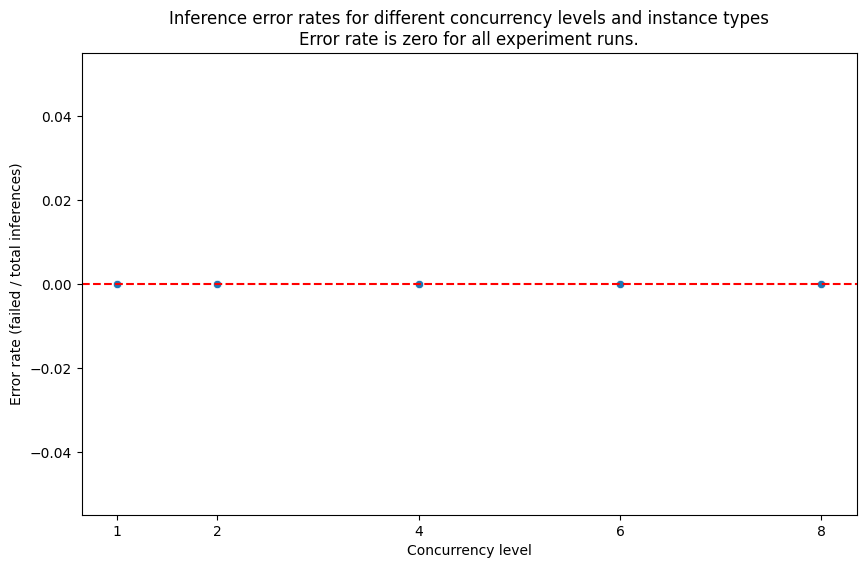

In [19]:
df_error_rates = df_error_rates.rename(columns={"instance_type": "instance", "payload_file": "dataset"})

# Clean up the dataset names by removing json file extensions and prefixes
df_error_rates.dataset = df_error_rates.dataset.map(lambda x: x.replace(".jsonl", "").replace("payload_", ""))

# this creates a facetGrid for plotting scatter plots based on 'instance' and 'dataset'
logger.info(f"df_error_rates --> {df_error_rates}")

df_error_rates_only_nz = df_error_rates[df_error_rates.error_rate > 0]
logger.info(f"there are {df_error_rates_only_nz.shape[0]} experiment runs that encountered errors")
if df_error_rates_only_nz.shape[0] > 0:    
    g = sns.FacetGrid(df_error_rates_only_nz, col="instance", row="dataset", hue="instance", height=3.5, aspect=1.25)
    # Maps a scatterplot to the FacetGrid for each subset of the data
    sns_plot = g.map(sns.scatterplot, "concurrency", "error_rate")
    # flatten axes into a 1-d array
    axes = g.axes.flatten()

    # iterate through the axes
    for i, ax in enumerate(axes):
        ax.axhline(config['report']['error_rate_budget']*1000, ls='--', c='red')

    # Create a subtitle
    with sns.plotting_context('paper', font_scale = 1.3):
        g.fig.suptitle("Inference error rates for different concurrency levels and instance types\nOnly non-zero error rates shown.")
        g.set_titles(row_template="{row_name}", col_template="{col_name}", size=8)

    # Set x and y labels for this chart
    g = g.set_ylabels("Error rate (failed / total inferences)")
    g = g.set_xlabels("Concurrency level")
    g.figure.subplots_adjust(top=.8)
    sns_plot.savefig(buffer, format='png')
    buffer.seek(0)
else:
    # create a new dummy dataframe just for plotting an empty chart
    
    df_error_rates_only_nz = pd.DataFrame({"concurrency": df_error_rates.concurrency.unique(),
                                           "error_rate": [0]*len(df_error_rates.concurrency.unique())
                                          })
    sns_plot = sns.scatterplot(data=df_error_rates_only_nz, x="concurrency", y="error_rate")
    sns_plot.set_xticks(df_error_rates_only_nz.concurrency.unique())
    sns_plot.set(xlabel="Concurrency level",
                 ylabel="Error rate (failed / total inferences)",
                 title="Inference error rates for different concurrency levels and instance types\nError rate is zero for all experiment runs.")
    sns_plot.axhline(config['report']['error_rate_budget']*1000, ls='--', c='red')
    sns_plot.figure.savefig(buffer, format='png')
    buffer.seek(0)

# Write the plot to S3
write_to_s3(buffer.getvalue(), BUCKET_NAME, "", METRICS_DIR, ERROR_RATES_PLOT_FNAME)
logger.info(f"Plot saved to s3://{BUCKET_NAME}/{METRICS_DIR}/{ERROR_RATES_PLOT_FNAME}")

## Display the plot 
sns_plot

#### Check for the df elements that have error rates above 0

In [20]:
df_error_rates_nz = df_error_rates[df_error_rates.error_rate > 0]
df_error_rates_nz

,experiment_name,dataset,instance,concurrency,error_rate


In [21]:
## initialize a dataframe to get the mean of the columns in consideration
df_summary_metrics = df_all_metrics[relevant_cols].groupby(group_by_cols).mean().reset_index()

# ugly way of doing this, will refactor this later (maybe)
df_summary_metrics.fillna(PLACE_HOLDER, inplace=True)
int_cols = ['prompt_token_count_mean', 'prompt_token_throughput', 'completion_token_count_mean', 'completion_token_throughput', 'transactions_per_minute']
for ic in int_cols:
    df_summary_metrics[ic] = df_summary_metrics[ic].astype(int)

df_summary_metrics.replace(PLACE_HOLDER, np.nan, inplace=True)
df_summary_metrics.latency_mean	= df_summary_metrics.latency_mean.round(2)
df_summary_metrics.latency_p50 = df_summary_metrics.latency_p50.round(2)
df_summary_metrics.latency_p95 = df_summary_metrics.latency_p95.round(2)
df_summary_metrics.latency_p99 = df_summary_metrics.latency_p99.round(2)
df_summary_metrics.error_rate	= df_summary_metrics.error_rate.round(2)

csv_buffer = io.StringIO()
df_summary_metrics.to_csv(csv_buffer, index=False)
summary_metrics_csv = csv_buffer.getvalue()

# Define the file name for S3 based on the original file path
summary_file_name = all_metrics_fpath.replace("all_metrics", "all_metrics_summary").split('/')[-1] 
summary_s3_path = os.path.join(METRICS_DIR, summary_file_name)  # Define full S3 path

# Write the CSV data to S3
write_to_s3(summary_metrics_csv, BUCKET_NAME, "", METRICS_DIR, summary_file_name)
logger.info(f"Summary metrics DataFrame saved to s3://{BUCKET_NAME}/{summary_s3_path}")

df_summary_metrics

[2024-05-05 22:13:54,208] p21340 {2129385706.py:27} INFO - Summary metrics DataFrame saved to s3://sagemaker-fmbench-write-us-east-1-015469603702/llama2-13b-inf2-g5-p4d-v2-SageMaker/data/metrics/yyyy=2024/mm=05/dd=05/hh=19/mm=28/all_metrics_summary.csv


,experiment_name,payload_file,instance_type,concurrency,error_rate,prompt_token_count_mean,prompt_token_throughput,completion_token_count_mean,completion_token_throughput,latency_mean,latency_p50,latency_p95,latency_p99,transactions_per_minute
0,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_1-500.jsonl,ml.g5.12xlarge,1,0.0,304,394,26,33,0.77,0.77,0.77,0.77,78
1,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_1-500.jsonl,ml.g5.12xlarge,2,0.0,304,745,26,63,0.81,0.81,0.81,0.81,147
2,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_1-500.jsonl,ml.g5.12xlarge,4,0.0,304,1124,26,96,1.06,1.06,1.07,1.07,222
3,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_1-500.jsonl,ml.g5.12xlarge,6,0.0,304,1363,25,112,1.31,1.31,1.33,1.33,268
4,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_1-500.jsonl,ml.g5.12xlarge,8,0.0,304,1473,25,124,1.62,1.63,1.63,1.63,291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,llama2-13b-p4d.24xlarge-tgi-inference-2.0.1-tg...,payload_en_500-1000.jsonl,ml.p4d.24xlarge,1,0.0,980,2186,16,35,0.44,0.44,0.44,0.44,133
146,llama2-13b-p4d.24xlarge-tgi-inference-2.0.1-tg...,payload_en_500-1000.jsonl,ml.p4d.24xlarge,2,0.0,980,4278,16,69,0.45,0.45,0.45,0.45,262
147,llama2-13b-p4d.24xlarge-tgi-inference-2.0.1-tg...,payload_en_500-1000.jsonl,ml.p4d.24xlarge,4,0.0,980,7777,16,126,0.49,0.49,0.49,0.49,476
148,llama2-13b-p4d.24xlarge-tgi-inference-2.0.1-tg...,payload_en_500-1000.jsonl,ml.p4d.24xlarge,6,0.0,980,6502,16,106,0.59,0.54,0.80,0.88,397


In [22]:
df_summary_metrics_nz = df_summary_metrics[df_summary_metrics.error_rate == 0]
logger.info(f"there are {len(df_summary_metrics_nz)} entries out of {len(df_summary_metrics)} in the summary data for which error rate is 0")

[2024-05-05 22:13:54,233] p21340 {3483828648.py:2} INFO - there are 150 entries out of 150 in the summary data for which error rate is 0


In [23]:
df_summary_metrics_dataset = df_summary_metrics[df_summary_metrics.payload_file.str.contains(config['metrics']['dataset_of_interest'])]
logger.info(f"shape of dataframe with summary metrics for {config['metrics']['dataset_of_interest']} is {df_summary_metrics_dataset.shape}")

csv_buffer = io.StringIO()
df_summary_metrics_dataset.to_csv(csv_buffer, index=False)
metrics_dataset = csv_buffer.getvalue()

# Write the CSV data to S3
write_to_s3(metrics_dataset, BUCKET_NAME, "", METRICS_DIR, SUMMARY_METRICS_W_PRICING_FNAME)
logger.info(f"Summary metrics dataset saved to s3://{BUCKET_NAME}/{METRICS_DIR}/{SUMMARY_METRICS_W_PRICING_FNAME}")

df_summary_metrics_dataset

[2024-05-05 22:13:54,241] p21340 {2401216161.py:2} INFO - shape of dataframe with summary metrics for en_3000-3840 is (30, 14)
[2024-05-05 22:13:54,310] p21340 {2401216161.py:10} INFO - Summary metrics dataset saved to s3://sagemaker-fmbench-write-us-east-1-015469603702/llama2-13b-inf2-g5-p4d-v2-SageMaker/data/metrics/yyyy=2024/mm=05/dd=05/hh=19/mm=28/summary_metrics_w_pricing.csv


,experiment_name,payload_file,instance_type,concurrency,error_rate,prompt_token_count_mean,prompt_token_throughput,completion_token_count_mean,completion_token_throughput,latency_mean,latency_p50,latency_p95,latency_p99,transactions_per_minute
15,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.12xlarge,1,0.0,3394,1764,30,13,2.03,2.03,2.03,2.03,30
16,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.12xlarge,2,0.0,3394,1863,31,15,3.48,3.48,3.71,3.73,32
17,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.12xlarge,4,0.0,3394,1938,29,16,5.65,5.84,6.97,7.04,33
18,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.12xlarge,6,0.0,3394,1950,31,17,7.60,7.76,10.30,10.45,34
19,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.12xlarge,8,0.0,3394,1984,30,17,9.48,9.86,13.54,13.67,35
40,llama2-13b-g5.24xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.24xlarge,1,0.0,3394,1763,30,13,2.03,2.03,2.03,2.03,30
41,llama2-13b-g5.24xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.24xlarge,2,0.0,3394,1901,30,15,3.42,3.42,3.63,3.65,33
42,llama2-13b-g5.24xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.24xlarge,4,0.0,3394,1932,30,16,5.75,5.97,6.98,7.05,33
43,llama2-13b-g5.24xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.24xlarge,6,0.0,3394,1928,31,17,7.71,8.11,10.42,10.58,33
44,llama2-13b-g5.24xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.24xlarge,8,0.0,3394,1967,30,17,9.42,9.84,13.57,13.77,34


[2024-05-05 22:13:54,347] p21340 {3986935425.py:10} ERROR - found 588 experiment runs for ds=en_3000-3840
[2024-05-05 22:13:54,932] p21340 {category.py:223} INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2024-05-05 22:13:54,945] p21340 {category.py:223} INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2024-05-05 22:13:56,311] p21340 {3986935425.py:34} INFO - Plot saved to s3://sagemaker-fmbench-write-us-east-1-015469603702/llama2-13b-inf2-g5-p4d-v2-SageMaker/data/metrics/yyyy=2024/mm=05/dd=05/hh=19/mm=28/concurrency_vs_inference_latency.png


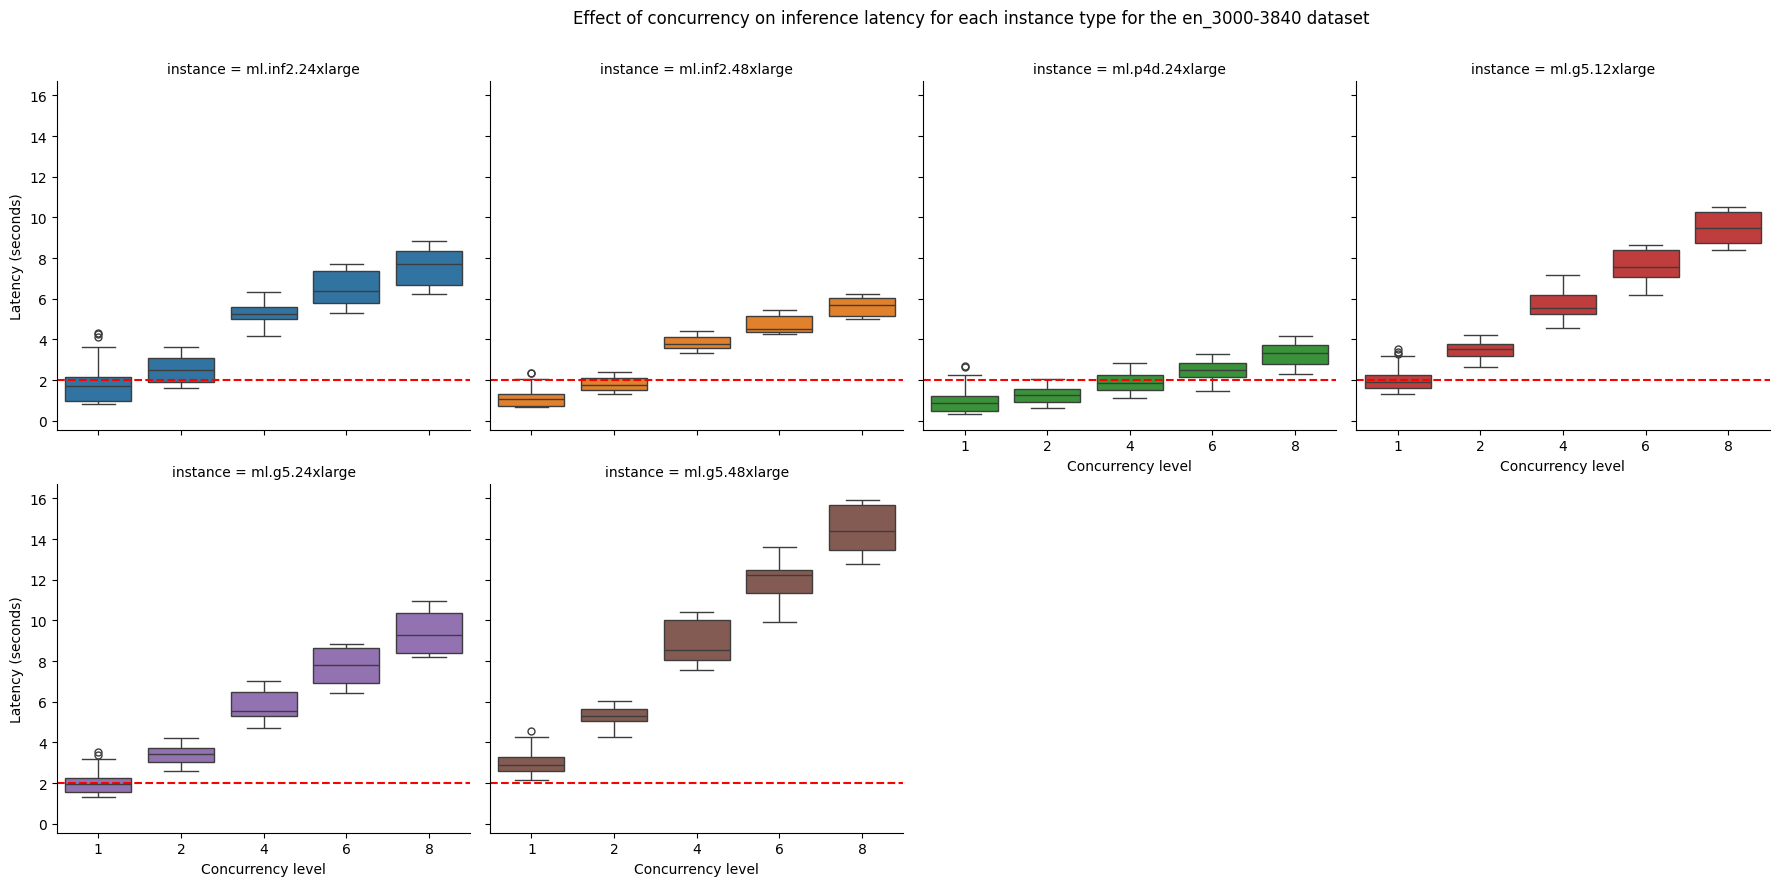

In [24]:
df_all_metrics_for_dataset = df_all_metrics.rename(columns={"instance_type": "instance", "payload_file": "dataset"})
df_all_metrics_for_dataset.dataset = df_all_metrics_for_dataset.dataset.map(lambda x: x.replace(".jsonl", "").replace("payload_", ""))
ds = config['metrics']['dataset_of_interest']
df_all_metrics_for_dataset = df_all_metrics_for_dataset[df_all_metrics_for_dataset.dataset.str.contains(ds)]
row_order = list(df_all_metrics_for_dataset[["instance", "latency_mean"]].groupby("instance").mean("latency_mean").reset_index()["instance"])
if len(row_order) == 0:
    logger.error(f"seems like a missing configuration, no data found in df_all_metrics_for_dataset for ds={ds}")
    col_wrap = 1
else:    
    logger.error(f"found {df_all_metrics_for_dataset.shape[0]} experiment runs for ds={ds}")
    col_wrap = 4 if len(row_order) > 4 else len(row_order)

    sns_plot = sns.catplot(
        data=df_all_metrics_for_dataset, x='concurrency', y='latency_mean',
        col='instance', kind='box', col_wrap=col_wrap, hue="instance", row_order=row_order, height=4.5, aspect=1.0
    )
    # flatten axes into a 1-d array
    axes = sns_plot.axes.flatten()

    # iterate through the axes
    for i, ax in enumerate(axes):
        ax.axhline(config['report']['latency_budget'], ls='--', c='red')
    sns_plot._legend.remove()
    sns_plot.fig.suptitle(f"Effect of concurrency on inference latency for each instance type for the {ds} dataset\n\n")
    sns_plot = sns_plot.set_ylabels("Latency (seconds)")
    sns_plot = sns_plot.set_xlabels("Concurrency level")
    sns_plot.fig.subplots_adjust(top=0.9)

    sns_plot.savefig(buffer, format='png')
    buffer.seek(0)

    # Write the plot to S3
    write_to_s3(buffer.getvalue(), BUCKET_NAME, "", METRICS_DIR, CONCURRENCY_VS_INFERENCE_LATENCY_PLOT_FNAME)
    logger.info(f"Plot saved to s3://{BUCKET_NAME}/{METRICS_DIR}/{CONCURRENCY_VS_INFERENCE_LATENCY_PLOT_FNAME}")

In [25]:
df_pricing = pd.DataFrame.from_dict(pricing_config['pricing'], orient='index').reset_index()
df_pricing

,index,ml.m5.xlarge,ml.g5.xlarge,ml.g5.2xlarge,ml.g5.12xlarge,ml.g5.24xlarge,ml.g5.48xlarge,ml.inf2.xlarge,ml.inf2.8xlarge,ml.inf2.24xlarge,...,mistral.mistral-7b-instruct-v0:2,mistral.mixtral-8x7b-instruct-v0:1,meta.llama3-8b-instruct-v1:0,meta.llama3-70b-instruct-v1:0,meta.llama2-13b-chat-v1,meta.llama2-70b-chat-v1,ai21.j2-mid-v1,ai21.j2-ultra-v1,cohere.command-text-v14,cohere.command-light-text-v14
0,instance_based,0.23,1.006,1.212,7.09,10.18,20.36,0.7582,1.968,6.491,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,token_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"{'input-per-1k-tokens': 0.00015, 'output-per-1...","{'input-per-1k-tokens': 0.00045, 'output-per-1...","{'input-per-1k-tokens': 0.0004, 'output-per-1k...","{'input-per-1k-tokens': 0.00265, 'output-per-1...","{'input-per-1k-tokens': 0.00075, 'output-per-1...","{'input-per-1k-tokens': 0.00195, 'output-per-1...","{'input-per-1k-tokens': 0.0125, 'output-per-1k...","{'input-per-1k-tokens': 0.0188, 'output-per-1k...","{'input-per-1k-tokens': 0.0015, 'output-per-1k...","{'input-per-1k-tokens': 0.0003, 'output-per-1k..."


In [26]:
df_summary_metrics_dataset

,experiment_name,payload_file,instance_type,concurrency,error_rate,prompt_token_count_mean,prompt_token_throughput,completion_token_count_mean,completion_token_throughput,latency_mean,latency_p50,latency_p95,latency_p99,transactions_per_minute
15,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.12xlarge,1,0.0,3394,1764,30,13,2.03,2.03,2.03,2.03,30
16,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.12xlarge,2,0.0,3394,1863,31,15,3.48,3.48,3.71,3.73,32
17,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.12xlarge,4,0.0,3394,1938,29,16,5.65,5.84,6.97,7.04,33
18,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.12xlarge,6,0.0,3394,1950,31,17,7.60,7.76,10.30,10.45,34
19,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.12xlarge,8,0.0,3394,1984,30,17,9.48,9.86,13.54,13.67,35
40,llama2-13b-g5.24xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.24xlarge,1,0.0,3394,1763,30,13,2.03,2.03,2.03,2.03,30
41,llama2-13b-g5.24xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.24xlarge,2,0.0,3394,1901,30,15,3.42,3.42,3.63,3.65,33
42,llama2-13b-g5.24xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.24xlarge,4,0.0,3394,1932,30,16,5.75,5.97,6.98,7.05,33
43,llama2-13b-g5.24xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.24xlarge,6,0.0,3394,1928,31,17,7.71,8.11,10.42,10.58,33
44,llama2-13b-g5.24xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.24xlarge,8,0.0,3394,1967,30,17,9.42,9.84,13.57,13.77,34


### Handle pricing for token based pricing & hourly (instance type) pricing models

In [27]:
def calculate_cost_per_txn(row: pd.Series, pricing: Dict) -> Optional[float]:
    """
    The instance type is supposed to be unique across all inference options
    whether it is hourly pricing based instances (g5/p4 etc.) or Bedrock
    model ids or anything else.
    """

    cost_per_txn: Optional[float] = None
    # check if this is instance type
    pricing_for_this_instance = pricing['pricing']['instance_based'].get(row['instance_type'])
    if pricing_for_this_instance:
        # this is instance based pricing so then cost per txn is simply
        logger.info(f"pricing for {row['instance_type']} -> {pricing_for_this_instance}")
        if row['transactions_per_minute'] > 0:
            cost_per_txn = (pricing_for_this_instance / 60) / row['transactions_per_minute']
        else:
            logger.info(f"transactions_per_minute={row['transactions_per_minute']}, setting cost_per_txn=None")
            cost_per_txn = None
            
    else:
        # this is token based pricing
        token_based_pricing_this_model = pricing['pricing']['token_based'].get(row['instance_type'])
        logger.info(f"pricing for {row['instance_type']} -> {token_based_pricing_this_model}")
        if token_based_pricing_this_model:
            input_token_cost = (row['prompt_token_count_mean']/1000) * \
                                token_based_pricing_this_model['input-per-1k-tokens']
            output_token_cost = (row['completion_token_count_mean']/1000) * \
                                token_based_pricing_this_model['output-per-1k-tokens']
            cost_per_txn = input_token_cost + output_token_cost
        else:
            logger.error(f"no pricing information found for {row['instance_type']}")
    return cost_per_txn

In [28]:
df_summary_metrics_dataset['price_per_txn'] = df_summary_metrics_dataset.apply(lambda r: calculate_cost_per_txn(r, pricing_config),
                                                                               axis=1)

[2024-05-05 22:13:57,129] p21340 {970195528.py:13} INFO - pricing for ml.g5.12xlarge -> 7.09
[2024-05-05 22:13:57,130] p21340 {970195528.py:13} INFO - pricing for ml.g5.12xlarge -> 7.09
[2024-05-05 22:13:57,130] p21340 {970195528.py:13} INFO - pricing for ml.g5.12xlarge -> 7.09
[2024-05-05 22:13:57,131] p21340 {970195528.py:13} INFO - pricing for ml.g5.12xlarge -> 7.09
[2024-05-05 22:13:57,131] p21340 {970195528.py:13} INFO - pricing for ml.g5.12xlarge -> 7.09
[2024-05-05 22:13:57,133] p21340 {970195528.py:13} INFO - pricing for ml.g5.24xlarge -> 10.18
[2024-05-05 22:13:57,133] p21340 {970195528.py:13} INFO - pricing for ml.g5.24xlarge -> 10.18
[2024-05-05 22:13:57,134] p21340 {970195528.py:13} INFO - pricing for ml.g5.24xlarge -> 10.18
[2024-05-05 22:13:57,135] p21340 {970195528.py:13} INFO - pricing for ml.g5.24xlarge -> 10.18
[2024-05-05 22:13:57,136] p21340 {970195528.py:13} INFO - pricing for ml.g5.24xlarge -> 10.18
[2024-05-05 22:13:57,136] p21340 {970195528.py:13} INFO - pricing

In [29]:
df_summary_metrics_dataset['price_per_token'] = (df_summary_metrics_dataset['price_per_txn'] / 
                                                (df_summary_metrics_dataset['prompt_token_count_mean'] + 
                                                 df_summary_metrics_dataset['completion_token_count_mean']))

df_summary_metrics_dataset['price_per_token'] = df_summary_metrics_dataset['price_per_token'].apply(lambda x: '{:.8f}'.format(x))

/tmp/ipykernel_21340/3444174930.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_summary_metrics_dataset['price_per_token'] = (df_summary_metrics_dataset['price_per_txn'] /
/tmp/ipykernel_21340/3444174930.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_summary_metrics_dataset['price_per_token'] = df_summary_metrics_dataset['price_per_token'].apply(lambda x: '{:.8f}'.format(x))


In [30]:
df_summary_metrics_dataset

,experiment_name,payload_file,instance_type,concurrency,error_rate,prompt_token_count_mean,prompt_token_throughput,completion_token_count_mean,completion_token_throughput,latency_mean,latency_p50,latency_p95,latency_p99,transactions_per_minute,price_per_txn,price_per_token
15,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.12xlarge,1,0.0,3394,1764,30,13,2.03,2.03,2.03,2.03,30,0.003939,0.00000115
16,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.12xlarge,2,0.0,3394,1863,31,15,3.48,3.48,3.71,3.73,32,0.003693,0.00000108
17,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.12xlarge,4,0.0,3394,1938,29,16,5.65,5.84,6.97,7.04,33,0.003581,0.00000105
18,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.12xlarge,6,0.0,3394,1950,31,17,7.60,7.76,10.30,10.45,34,0.003475,0.00000101
19,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.12xlarge,8,0.0,3394,1984,30,17,9.48,9.86,13.54,13.67,35,0.003376,0.00000099
40,llama2-13b-g5.24xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.24xlarge,1,0.0,3394,1763,30,13,2.03,2.03,2.03,2.03,30,0.005656,0.00000165
41,llama2-13b-g5.24xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.24xlarge,2,0.0,3394,1901,30,15,3.42,3.42,3.63,3.65,33,0.005141,0.00000150
42,llama2-13b-g5.24xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.24xlarge,4,0.0,3394,1932,30,16,5.75,5.97,6.98,7.05,33,0.005141,0.00000150
43,llama2-13b-g5.24xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.24xlarge,6,0.0,3394,1928,31,17,7.71,8.11,10.42,10.58,33,0.005141,0.00000150
44,llama2-13b-g5.24xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.24xlarge,8,0.0,3394,1967,30,17,9.42,9.84,13.57,13.77,34,0.004990,0.00000146


In [31]:
def score_run(row: pd.core.series.Series, config: Dict) -> Dict:
    """
    check all criteria configured in the report section of the config
    these are error rates, latency and cost to determine the "score"
    for each run in the following way:
    1. Set score to 0, criteria failed to false.
    2. If the run has an error rate lte to the error rate budget,
       add 1 to the score otherwise set set criteria failed to true.
    3. If the run has a price per 10k txns lte to the cost budget,
       add 1 to the score otherwise set set criteria failed to true.
    4. If the run has average latency lte to the latency budget,
       add 1 to the score otherwise set set criteria failed to true.
    5. If criteria failed is false add the concurrency to the score.
    The idea that we want to select runs that satisfy cost/error rate/latency criteria
    and out of those prefer the run with the highest level of concurrency.
    """
    score: float = 0
    point_per_criterion: int = 1
    any_criterion_failed: bool = False
    error_rate_criterion_failed: bool = False
    cost_per_txn_criterion_failed: bool = False
    latency_criterion_failed: bool = False

    mk_text_green = lambda k, m=1: f"<span style='color:green'>{row[k]*m:0.2f}</span>"
    mk_text_red = lambda k, m=1: f"<span style='color:red'>**{row[k]*m:0.2f}**</span>"
    mk_text_red2 = lambda k: f"<span style='color:red'>**{row[k]}**</span>"
    
    # error rate
    threshold: float = config['report'].get('error_rate_budget', 0)
    if row['error_rate'] <= threshold:
        score += point_per_criterion
        error_rate_text = mk_text_green('error_rate')
    else:
        error_rate_criterion_failed = True
        error_rate_text = mk_text_red('error_rate')
        logger.info(f"score_run, experiment_name={row['experiment_name']}, setting "
                    f"error_rate_criterion_failed={error_rate_criterion_failed} because "
                    f"error_rate={row['error_rate']} > threshold={threshold}")

    # latency
    threshold: float = config['report'].get('latency_budget', 10)
    if row['latency_mean'] <= threshold:
        # extra points for better latency
        score += point_per_criterion + (threshold-row['latency_mean'])/threshold
        latency_mean_text = mk_text_green('latency_mean')
    else:
        latency_criterion_failed = True
        latency_mean_text = mk_text_red('latency_mean')
        logger.info(f"score_run, experiment_name={row['experiment_name']}, setting "
                    f"latency_criterion_failed={latency_criterion_failed} because "
                    f"latency_mean={row['latency_mean']} > threshold={threshold}")

    # cost_per_10k_txn_budget
    threshold: float = config['report'].get('cost_per_10k_txn_budget', 5)
    if row['price_per_txn'] and row['price_per_txn'] * 10000 <= threshold:
        # extra points for better price
        score += point_per_criterion + (threshold-row['price_per_txn'])/threshold     
        price_per_10k_txn_text = mk_text_green('price_per_txn', m=10000)
    else:
        cost_per_txn_criterion_failed = True
        if row['price_per_txn']:
            price_per_10k_txn_text = mk_text_red('price_per_txn', m=10000)
            cost_per_10k_txn = row['price_per_txn'] * 10000
        else:
            cost_per_10k_txn = None
            price_per_10k_txn_text = mk_text_red2('price_per_txn')

        logger.info(f"score_run, experiment_name={row['experiment_name']}, setting "
                    f"cost_per_txn_criterion_failed={cost_per_txn_criterion_failed} because "
                    f"cost_per_10k_txn={cost_per_10k_txn} > threshold={threshold}")

    # if all criteria passed then add points for concurrency
    # we want to select the run with the highest concurrency amongst
    # all runs that satisfy all criteria
    any_criterion_failed = error_rate_criterion_failed or \
                           latency_criterion_failed or \
                           cost_per_txn_criterion_failed

    if any_criterion_failed is True:
        logger.info(f"experiment_name={row['experiment_name']}, not adding points for "
                    f"concurrency because any_criterion_failed={any_criterion_failed}")
    else:
        score += row['concurrency']

    score_dict = dict(score=score,
                      any_criterion_failed=any_criterion_failed,
                      error_rate_criterion_failed=error_rate_criterion_failed,
                      latency_criterion_failed=latency_criterion_failed,
                      cost_per_txn_criterion_failed=cost_per_txn_criterion_failed,
                      error_rate_text=error_rate_text,
                      latency_mean_text=latency_mean_text,
                      price_per_10k_txn_text=price_per_10k_txn_text)
    logger.info(json.dumps(row.to_dict() | score_dict, indent=2, default=str))
    return score_dict

In [32]:
df_summary_metrics_dataset['score_dict'] = df_summary_metrics_dataset.apply(lambda row: score_run(row, config), axis=1)
score_keys = df_summary_metrics_dataset.score_dict.iloc[0].keys()
for k in score_keys:
    df_summary_metrics_dataset[k] = df_summary_metrics_dataset.score_dict.map(lambda d: d[k])

[2024-05-05 22:13:57,199] p21340 {910258534.py:49} INFO - score_run, experiment_name=llama2-13b-g5.12xlarge-huggingface-pytorch-tgi-inference-2.0.1-tgi1.1.0, setting latency_criterion_failed=True because latency_mean=2.03 > threshold=2
[2024-05-05 22:13:57,201] p21340 {910258534.py:80} INFO - experiment_name=llama2-13b-g5.12xlarge-huggingface-pytorch-tgi-inference-2.0.1-tgi1.1.0, not adding points for concurrency because any_criterion_failed=True
[2024-05-05 22:13:57,201] p21340 {910258534.py:93} INFO - {
  "experiment_name": "llama2-13b-g5.12xlarge-huggingface-pytorch-tgi-inference-2.0.1-tgi1.1.0",
  "payload_file": "payload_en_3000-3840.jsonl",
  "instance_type": "ml.g5.12xlarge",
  "concurrency": 1,
  "error_rate": 0.0,
  "prompt_token_count_mean": 3394,
  "prompt_token_throughput": 1764,
  "completion_token_count_mean": 30,
  "completion_token_throughput": 13,
  "latency_mean": 2.03,
  "latency_p50": 2.03,
  "latency_p95": 2.03,
  "latency_p99": 2.03,
  "transactions_per_minute": 3

In [33]:
# select the best option overall and for each instance type
df_summary_metrics_dataset_overall = df_summary_metrics_dataset[df_summary_metrics_dataset.score == df_summary_metrics_dataset.score.max()]

csv_buffer = io.StringIO()
df_summary_metrics_dataset_overall.to_csv(csv_buffer, index=False)
metrics_overall_data = csv_buffer.getvalue()

# Write the CSV data to S3
write_to_s3(metrics_overall_data, BUCKET_NAME, "", METRICS_DIR, SUMMARY_METRICS_FOR_DATASET_W_SCORES_BEST_OPTION_FNAME)

df_summary_metrics_dataset_overall

,experiment_name,payload_file,instance_type,concurrency,error_rate,prompt_token_count_mean,prompt_token_throughput,completion_token_count_mean,completion_token_throughput,latency_mean,...,price_per_token,score_dict,score,any_criterion_failed,error_rate_criterion_failed,latency_criterion_failed,cost_per_txn_criterion_failed,error_rate_text,latency_mean_text,price_per_10k_txn_text
116,llama2-13b-inf2.48xlarge-djl-0.24.0-neuronx-sd...,payload_en_3000-3840.jsonl,ml.inf2.48xlarge,2,0.0,3394,3622,31,28,1.79,...,0.00000100,"{'score': 6.104931317460317, 'any_criterion_fa...",6.104931,False,False,False,False,<span style='color:green'>0.00</span>,<span style='color:green'>1.79</span>,<span style='color:green'>34.34</span>


In [34]:
df_summary_metrics_dataset_overall = df_summary_metrics_dataset_overall.round(6)
df_summary_metrics_dataset_overall.to_dict(orient='records')

[{'experiment_name': 'llama2-13b-inf2.48xlarge-djl-0.24.0-neuronx-sdk-2.14.1-bs=4-tpd=24',
  'payload_file': 'payload_en_3000-3840.jsonl',
  'instance_type': 'ml.inf2.48xlarge',
  'concurrency': 2,
  'error_rate': 0.0,
  'prompt_token_count_mean': 3394,
  'prompt_token_throughput': 3622,
  'completion_token_count_mean': 31,
  'completion_token_throughput': 28,
  'latency_mean': 1.79,
  'latency_p50': 1.79,
  'latency_p95': 1.97,
  'latency_p99': 1.98,
  'transactions_per_minute': 63,
  'price_per_txn': 0.003434,
  'price_per_token': '0.00000100',
  'score_dict': {'score': 6.104931317460317,
   'any_criterion_failed': False,
   'error_rate_criterion_failed': False,
   'latency_criterion_failed': False,
   'cost_per_txn_criterion_failed': False,
   'error_rate_text': "<span style='color:green'>0.00</span>",
   'latency_mean_text': "<span style='color:green'>1.79</span>",
   'price_per_10k_txn_text': "<span style='color:green'>34.34</span>"},
  'score': 6.104931,
  'any_criterion_failed':

In [35]:
df_summary_metrics_dataset = df_summary_metrics_dataset.dropna()
idx = df_summary_metrics_dataset.groupby(['instance_type']).score.idxmax()
logger.info(f"shape of df_summary_metrics_dataset={df_summary_metrics_dataset.shape}, idx={idx}")
df_summary_metrics_best_option_instance_type = df_summary_metrics_dataset.loc[idx]
logger.info(f"shape of df_summary_metrics_best_option_instance_type={df_summary_metrics_best_option_instance_type.shape}")

csv_buffer = io.StringIO()
df_summary_metrics_best_option_instance_type.to_csv(csv_buffer, index=False)
best_option = csv_buffer.getvalue()

# Write the CSV data to S3
write_to_s3(best_option, BUCKET_NAME, "", METRICS_DIR, SUMMARY_METRICS_FOR_DATASET_W_SCORES_BEST_OPTION_EACH_INSTANCE_TYPE_FNAME)

df_summary_metrics_best_option_instance_type


[2024-05-05 22:13:57,385] p21340 {2557499297.py:3} INFO - shape of df_summary_metrics_dataset=(30, 25), idx=instance_type
ml.g5.12xlarge       19
ml.g5.24xlarge       44
ml.g5.48xlarge       65
ml.inf2.24xlarge     90
ml.inf2.48xlarge    116
ml.p4d.24xlarge     140
Name: score, dtype: int64
[2024-05-05 22:13:57,386] p21340 {2557499297.py:5} INFO - shape of df_summary_metrics_best_option_instance_type=(6, 25)


,experiment_name,payload_file,instance_type,concurrency,error_rate,prompt_token_count_mean,prompt_token_throughput,completion_token_count_mean,completion_token_throughput,latency_mean,...,price_per_token,score_dict,score,any_criterion_failed,error_rate_criterion_failed,latency_criterion_failed,cost_per_txn_criterion_failed,error_rate_text,latency_mean_text,price_per_10k_txn_text
19,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.12xlarge,8,0.0,3394,1984,30,17,9.48,...,0.00000099,"{'score': 2.999932476190476, 'any_criterion_fa...",2.999932,True,False,True,False,<span style='color:green'>0.00</span>,<span style='color:red'>**9.48**</span>,<span style='color:green'>33.76</span>
44,llama2-13b-g5.24xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.24xlarge,8,0.0,3394,1967,30,17,9.42,...,0.00000146,"{'score': 2.9999001960784315, 'any_criterion_f...",2.999900,True,False,True,False,<span style='color:green'>0.00</span>,<span style='color:red'>**9.42**</span>,<span style='color:green'>49.90</span>
65,llama2-13b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.48xlarge,1,0.0,3394,1163,31,9,3.00,...,0.00000495,"{'score': 1, 'any_criterion_failed': True, 'er...",1.000000,True,False,True,True,<span style='color:green'>0.00</span>,<span style='color:red'>**3.00**</span>,<span style='color:red'>**169.67**</span>
90,llama2-13b-inf2.24xlarge-djl-0.24.0-neuronx-sd...,payload_en_3000-3840.jsonl,ml.inf2.24xlarge,1,0.0,3394,2315,31,14,1.80,...,0.00000079,"{'score': 5.099945908333334, 'any_criterion_fa...",5.099946,False,False,False,False,<span style='color:green'>0.00</span>,<span style='color:green'>1.80</span>,<span style='color:green'>27.05</span>
116,llama2-13b-inf2.48xlarge-djl-0.24.0-neuronx-sd...,payload_en_3000-3840.jsonl,ml.inf2.48xlarge,2,0.0,3394,3622,31,28,1.79,...,0.00000100,"{'score': 6.104931317460317, 'any_criterion_fa...",6.104931,False,False,False,False,<span style='color:green'>0.00</span>,<span style='color:green'>1.79</span>,<span style='color:green'>34.34</span>
140,llama2-13b-p4d.24xlarge-tgi-inference-2.0.1-tg...,payload_en_3000-3840.jsonl,ml.p4d.24xlarge,1,0.0,3394,4797,29,26,0.96,...,0.00000218,"{'score': 2.52, 'any_criterion_failed': True, ...",2.520000,True,False,False,True,<span style='color:green'>0.00</span>,<span style='color:green'>0.96</span>,<span style='color:red'>**74.78**</span>


In [36]:
df_summary_metrics_best_option_instance_type

,experiment_name,payload_file,instance_type,concurrency,error_rate,prompt_token_count_mean,prompt_token_throughput,completion_token_count_mean,completion_token_throughput,latency_mean,...,price_per_token,score_dict,score,any_criterion_failed,error_rate_criterion_failed,latency_criterion_failed,cost_per_txn_criterion_failed,error_rate_text,latency_mean_text,price_per_10k_txn_text
19,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.12xlarge,8,0.0,3394,1984,30,17,9.48,...,0.00000099,"{'score': 2.999932476190476, 'any_criterion_fa...",2.999932,True,False,True,False,<span style='color:green'>0.00</span>,<span style='color:red'>**9.48**</span>,<span style='color:green'>33.76</span>
44,llama2-13b-g5.24xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.24xlarge,8,0.0,3394,1967,30,17,9.42,...,0.00000146,"{'score': 2.9999001960784315, 'any_criterion_f...",2.999900,True,False,True,False,<span style='color:green'>0.00</span>,<span style='color:red'>**9.42**</span>,<span style='color:green'>49.90</span>
65,llama2-13b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.48xlarge,1,0.0,3394,1163,31,9,3.00,...,0.00000495,"{'score': 1, 'any_criterion_failed': True, 'er...",1.000000,True,False,True,True,<span style='color:green'>0.00</span>,<span style='color:red'>**3.00**</span>,<span style='color:red'>**169.67**</span>
90,llama2-13b-inf2.24xlarge-djl-0.24.0-neuronx-sd...,payload_en_3000-3840.jsonl,ml.inf2.24xlarge,1,0.0,3394,2315,31,14,1.80,...,0.00000079,"{'score': 5.099945908333334, 'any_criterion_fa...",5.099946,False,False,False,False,<span style='color:green'>0.00</span>,<span style='color:green'>1.80</span>,<span style='color:green'>27.05</span>
116,llama2-13b-inf2.48xlarge-djl-0.24.0-neuronx-sd...,payload_en_3000-3840.jsonl,ml.inf2.48xlarge,2,0.0,3394,3622,31,28,1.79,...,0.00000100,"{'score': 6.104931317460317, 'any_criterion_fa...",6.104931,False,False,False,False,<span style='color:green'>0.00</span>,<span style='color:green'>1.79</span>,<span style='color:green'>34.34</span>
140,llama2-13b-p4d.24xlarge-tgi-inference-2.0.1-tg...,payload_en_3000-3840.jsonl,ml.p4d.24xlarge,1,0.0,3394,4797,29,26,0.96,...,0.00000218,"{'score': 2.52, 'any_criterion_failed': True, ...",2.520000,True,False,False,True,<span style='color:green'>0.00</span>,<span style='color:green'>0.96</span>,<span style='color:red'>**74.78**</span>


[Text(0.0, 0, '0'), Text(20.0, 0, '20'), Text(40.0, 0, '40'), Text(60.0, 0, '60'), Text(80.0, 0, '80'), Text(100.0, 0, '100'), Text(120.0, 0, '120'), Text(140.0, 0, '140'), Text(160.0, 0, '160'), Text(180.0, 0, '180'), Text(50.0, 0, '$50\n(threshold)')]
v_shift=0.025
x=28.075, y=ml.inf2.24xlarge, text=40 txn/min,
concurrency=1,
1.8s per txn
v_shift=0.025
x=34.785, y=ml.g5.12xlarge, text=35 txn/min,
concurrency=8,
9.48s per txn
v_shift=0.025
x=35.365, y=ml.inf2.48xlarge, text=63 txn/min,
concurrency=2,
1.79s per txn
v_shift=0.025
x=50.925, y=ml.g5.24xlarge, text=34 txn/min,
concurrency=8,
9.42s per txn
v_shift=0.025
x=75.805, y=ml.p4d.24xlarge, text=84 txn/min,
concurrency=1,
0.96s per txn
v_shift=0.025
x=170.695, y=ml.g5.48xlarge, text=20 txn/min,
concurrency=1,
3.0s per txn


[2024-05-05 22:13:57,964] p21340 {3583847867.py:53} INFO - Plot saved to s3://sagemaker-fmbench-write-us-east-1-015469603702/llama2-13b-inf2-g5-p4d-v2-SageMaker/data/metrics/yyyy=2024/mm=05/dd=05/hh=19/mm=28/business_summary_barchart.png


<Axes: title={'center': 'Comparing performance of Llama2-13b for en_3000-3840 dataset'}, xlabel='Cost per 10,000 transactions (USD)'>

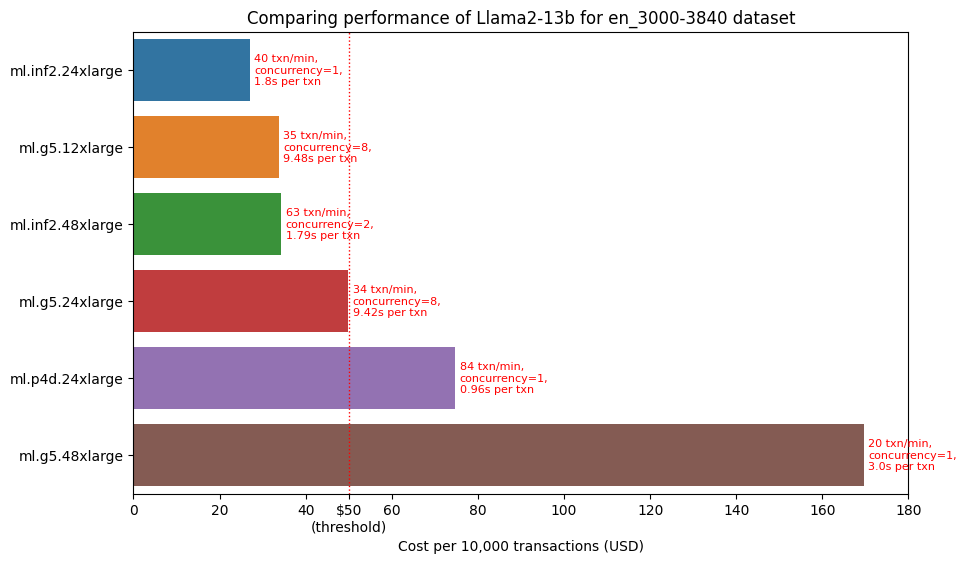

In [37]:
min_price_per_tx = df_summary_metrics_best_option_instance_type.price_per_txn.min()
txn_count_for_showing_cost: int = config["report"]["txn_count_for_showing_cost"]

price_tx_col_name = f"price_per_tx_{txn_count_for_showing_cost}_txn"
df_summary_metrics_best_option_instance_type[price_tx_col_name] = df_summary_metrics_best_option_instance_type.price_per_txn * txn_count_for_showing_cost
df_summary_metrics_best_option_instance_type[price_tx_col_name] = round(df_summary_metrics_best_option_instance_type[price_tx_col_name], 2)
df_summary_metrics_best_option_instance_type = df_summary_metrics_best_option_instance_type.sort_values(by=price_tx_col_name)
sns_plot = sns.barplot(df_summary_metrics_best_option_instance_type,
                       y="instance_type",
                       x=price_tx_col_name,
                       hue="instance_type",
                       orient='h')
sns_plot.axvline(x=config['report']['cost_per_10k_txn_budget'],
                 ls='dotted',
                 c='red',
                 linewidth=1) 
title: str = f"Comparing performance of {config['general']['model_name']} for {config['metrics']['dataset_of_interest']} dataset"
sns_plot.set(ylabel="", xlabel=f"Cost per {txn_count_for_showing_cost:,} transactions (USD)", title=title)

xticks = sns_plot.get_xticks()
xtick_labels = sns_plot.get_xticklabels()
#print(sns_plot.get_xticks(xticks))
sns_plot.set_xticks(np.append(xticks, config['report']['cost_per_10k_txn_budget']))
#print(sns_plot.get_xticks(xtick_labels))
sns_plot.set_xticklabels(np.append(xtick_labels,
                                   matplotlib.text.Text(config['report']['cost_per_10k_txn_budget'], 0, f"${config['report']['cost_per_10k_txn_budget']}\n(threshold)")))
print(sns_plot.get_xticklabels())
num_instance_types = len(df_summary_metrics_dataset.instance_type.unique())
for r in df_summary_metrics_best_option_instance_type.iterrows():
    y = r[1]['instance_type']
    if num_instance_types == 1:
        v_shift = config["report"]["v_shift_w_single_instance"]
    else:
        v_shift = config["report"]["v_shift_w_gt_one_instance"]
    
    print(f"v_shift={v_shift}")    
    x = r[1][price_tx_col_name] + v_shift + 1
    text = f"{r[1]['transactions_per_minute']} txn/min,\nconcurrency={r[1]['concurrency']},\n{r[1]['latency_mean']}s per txn"
    print(f"x={x}, y={y}, text={text}")
    sns_plot.text(x, y, text, 
       fontsize = 8,          # Size
       #fontstyle = "oblique",  # Style
       color = "red",          # Color
       ha = "left", # Horizontal alignment
       va = "center") # Vertical alignment 

business_summary_plot_fpath: str = os.path.join(METRICS_DIR, BUSINESS_SUMMARY_PLOT_FNAME2)
sns_plot.figure.savefig(buffer, format='png', bbox_inches='tight')
buffer.seek(0)

# Write the plot to S3
write_to_s3(buffer.getvalue(), BUCKET_NAME, "", "", business_summary_plot_fpath)
logger.info(f"Plot saved to s3://{BUCKET_NAME}/{business_summary_plot_fpath}")

# Display the plot 
sns_plot


In [38]:
df_summary_metrics_dataset['cost_per_10k_txn'] = df_summary_metrics_dataset.price_per_txn * 10000

[2024-05-05 22:15:49,706] p21340 {388900876.py:105} INFO - iter 0, r=3, c=2, v=1, best_price_perf_concurrency=2
[2024-05-05 22:15:49,707] p21340 {388900876.py:99} INFO - match found, r=3, c=2
[2024-05-05 22:15:49,709] p21340 {388900876.py:108} INFO - facet row col for best_price_perf, r=3, total_rows=3, best_facet_row=3, best_facet_col=2


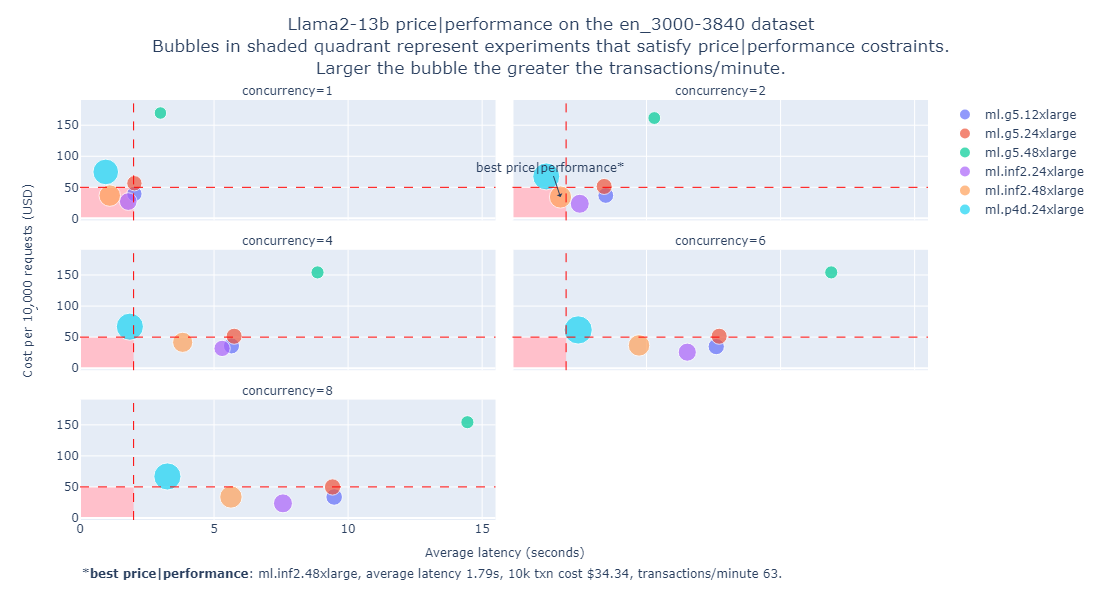

In [49]:
CHARTS_PER_ROW: int = 2
fig = px.scatter(df_summary_metrics_dataset,
                 x="latency_mean",
                 y="cost_per_10k_txn",
                 size="transactions_per_minute",
                 color="instance_type", #",
                 facet_col="concurrency",
                 #symbol ="concurrency",
                 facet_col_wrap=CHARTS_PER_ROW,
                 #text="instance_type",
                 log_y=False,
                 #size_max=10,
                 width=1000, height=600)

fig.for_each_yaxis(lambda y: y.update(title = ''))
fig.add_annotation(x=-0.05,y=0.5,
                   text="Cost per 10,000 requests (USD)", textangle=-90,
                   xref="paper", yref="paper")

fig.update_xaxes(title="")
fig.add_annotation(
    showarrow=False,
    xanchor='center',
    xref='paper', 
    x=0.5, 
    yref='paper',
    y=-0.1,
    text='Average latency (seconds)'
)

#fig.update_layout(xaxis2=dict(title="Average latency (seconds)"))

fig.update_layout(legend={'title_text':''})

fig.add_vline(x=config['report']['latency_budget'], line_width=1, line_dash="dash", line_color="red")
fig.add_hline(y=config['report']['cost_per_10k_txn_budget'], line_width=1, line_dash="dash", line_color="red")

fig.add_shape(
        type="rect",
        x0=0,
        y0=0,
        x1=config['report']['latency_budget'],
        y1=config['report']['cost_per_10k_txn_budget'],
        fillcolor="pink",
        line_width=0,
        layer="below",
        row='all',
        col='all',
        exclude_empty_subplots=True
    
    )

title: str = f"{config['general']['model_name']} price|performance on the {config['metrics']['dataset_of_interest']} dataset"
#subtitle: str = "Hover over bubbles in the shaded quadrant to see best best price|performance options."
subtitle: str = "Bubbles in shaded quadrant represent experiments that satisfy price|performance costraints.<br>Larger the bubble the greater the transactions/minute."

fig.update_layout(title=dict(
                      text=f"{title}<br>{subtitle}",
                      x=0.5,
                      y=0.95,
                      xanchor='center',
                      yanchor='top'))

fig.update_layout(margin=dict(t=100))
fig.update_xaxes(rangemode="nonnegative")
# fig.update_layout(legend=dict(
#     yanchor="bottom",
#     y=-0.425,
#     xanchor="left",
#     x=0.01
# ))

# now is the tricky part to add annotation for the best price performance
# we have to identify the correct facet for the best entry and then correct
# row and col index for that facet
# we first identify the best entry as a json dictionary
# to find the index we sort all the concurrency levens in asc order
# then find the row col index by iterating but we are iterating from 1,1
# which is at the top left because that is how we sett it visually
# but the facets row col counter starts at bottom left so the col counter is
# correct but the row counter needs to be inverted
best_price_perf = df_summary_metrics_dataset_overall.to_dict(orient='records')[0]
best_price_perf_x = best_price_perf['instance_type']
best_price_perf_y = best_price_perf['price_per_txn']*10000
best_price_perf_avg_latency = best_price_perf['latency_mean']
best_price_perf_cost_per_10k = best_price_perf['price_per_txn']*10000
best_price_perf_instance_type = best_price_perf['instance_type']
best_price_perf_tpm = best_price_perf['transactions_per_minute']
concurrencies = np.sort(df_summary_metrics_dataset.concurrency.unique())

concurrencies = list(df_summary_metrics_dataset.concurrency.unique())

c = 1
total_rows = math.ceil(len(concurrencies)/CHARTS_PER_ROW)
r = total_rows
for i, v in enumerate(np.sort(concurrencies)):
    if v == best_price_perf['concurrency']: #best_price_perf['concurrency']:
        logger.info(f"match found, r={r}, c={c}")
        break
    if c == CHARTS_PER_ROW:
        r -= 1
        c = 1
    c += 1
    logger.info(f"iter {i}, r={r}, c={c}, v={v}, best_price_perf_concurrency={best_price_perf['concurrency']}")
best_facet_row = r
best_facet_col = c
logger.info(f"facet row col for best_price_perf, r={r}, total_rows={total_rows}, "
            f"best_facet_row={best_facet_row}, best_facet_col={best_facet_col}")

fig.add_annotation(
        x=best_price_perf_avg_latency,
        y=best_price_perf_cost_per_10k,
        text="best price|performance*",
        row=best_facet_row,
        col=best_facet_col,
        showarrow=True,
        arrowhead=1)

fig.add_annotation(
    showarrow=False,
    xanchor='left',
    xref='paper', 
    x=0, 
    yref='paper',
    y=-0.15,
    text=f"*<b>best price|performance</b>: {best_price_perf_instance_type}, average latency {best_price_perf_avg_latency}s, 10k txn cost ${best_price_perf_cost_per_10k}, transactions/minute {best_price_perf_tpm}.",
)
fig.show()

In [40]:
business_summary_plot_fpath: str = os.path.join(METRICS_DIR, BUSINESS_SUMMARY_PLOT_FNAME)

local_path: str = os.path.join(tempfile.tempdir, BUSINESS_SUMMARY_PLOT_FNAME)
pio.write_image(fig, local_path) 
upload_file_to_s3(BUCKET_NAME, local_path, business_summary_plot_fpath)
logger.info(f"writing business summary image from {local_path} to s3://{BUCKET_NAME}/{business_summary_plot_fpath}")

[2024-05-05 22:14:00,046] p21340 {245086894.py:6} INFO - writing business summary image from /tmp/business_summary.png to s3://sagemaker-fmbench-write-us-east-1-015469603702/llama2-13b-inf2-g5-p4d-v2-SageMaker/data/metrics/yyyy=2024/mm=05/dd=05/hh=19/mm=28/business_summary.png


In [41]:
local_path: str = os.path.join(tempfile.tempdir, BUSINESS_SUMMARY_PLOT_FNAME.split('.')[0] + ".html")
fig.write_html(local_path)
business_summary_html_plot_fpath = business_summary_plot_fpath.split('.')[0] + ".html"
upload_file_to_s3(BUCKET_NAME, local_path, business_summary_html_plot_fpath)
logger.info(f"writing business summary image from {local_path} to s3://{BUCKET_NAME}/{business_summary_html_plot_fpath}")

[2024-05-05 22:14:00,280] p21340 {2012293385.py:5} INFO - writing business summary image from /tmp/business_summary.html to s3://sagemaker-fmbench-write-us-east-1-015469603702/llama2-13b-inf2-g5-p4d-v2-SageMaker/data/metrics/yyyy=2024/mm=05/dd=05/hh=19/mm=28/business_summary.html


In [42]:
display(df_summary_metrics_best_option_instance_type)

,experiment_name,payload_file,instance_type,concurrency,error_rate,prompt_token_count_mean,prompt_token_throughput,completion_token_count_mean,completion_token_throughput,latency_mean,...,score_dict,score,any_criterion_failed,error_rate_criterion_failed,latency_criterion_failed,cost_per_txn_criterion_failed,error_rate_text,latency_mean_text,price_per_10k_txn_text,price_per_tx_10000_txn
90,llama2-13b-inf2.24xlarge-djl-0.24.0-neuronx-sd...,payload_en_3000-3840.jsonl,ml.inf2.24xlarge,1,0.0,3394,2315,31,14,1.80,...,"{'score': 5.099945908333334, 'any_criterion_fa...",5.099946,False,False,False,False,<span style='color:green'>0.00</span>,<span style='color:green'>1.80</span>,<span style='color:green'>27.05</span>,27.05
19,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.12xlarge,8,0.0,3394,1984,30,17,9.48,...,"{'score': 2.999932476190476, 'any_criterion_fa...",2.999932,True,False,True,False,<span style='color:green'>0.00</span>,<span style='color:red'>**9.48**</span>,<span style='color:green'>33.76</span>,33.76
116,llama2-13b-inf2.48xlarge-djl-0.24.0-neuronx-sd...,payload_en_3000-3840.jsonl,ml.inf2.48xlarge,2,0.0,3394,3622,31,28,1.79,...,"{'score': 6.104931317460317, 'any_criterion_fa...",6.104931,False,False,False,False,<span style='color:green'>0.00</span>,<span style='color:green'>1.79</span>,<span style='color:green'>34.34</span>,34.34
44,llama2-13b-g5.24xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.24xlarge,8,0.0,3394,1967,30,17,9.42,...,"{'score': 2.9999001960784315, 'any_criterion_f...",2.999900,True,False,True,False,<span style='color:green'>0.00</span>,<span style='color:red'>**9.42**</span>,<span style='color:green'>49.90</span>,49.90
140,llama2-13b-p4d.24xlarge-tgi-inference-2.0.1-tg...,payload_en_3000-3840.jsonl,ml.p4d.24xlarge,1,0.0,3394,4797,29,26,0.96,...,"{'score': 2.52, 'any_criterion_failed': True, ...",2.520000,True,False,False,True,<span style='color:green'>0.00</span>,<span style='color:green'>0.96</span>,<span style='color:red'>**74.78**</span>,74.78
65,llama2-13b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_3000-3840.jsonl,ml.g5.48xlarge,1,0.0,3394,1163,31,9,3.00,...,"{'score': 1, 'any_criterion_failed': True, 'er...",1.000000,True,False,True,True,<span style='color:green'>0.00</span>,<span style='color:red'>**3.00**</span>,<span style='color:red'>**169.67**</span>,169.67


In [43]:
cost_csv_content_fpath = os.path.join(METRICS_DIR, SUMMARY_MODEL_ENDPOINT_COST_PER_INSTANCE)
logger.info(f"the cost information can be found in the csv file here -> {cost_csv_content_fpath}")

# Read the file from S3
try:
    cost_content = get_s3_object(BUCKET_NAME, cost_csv_content_fpath)

    # Use pandas to read the CSV content
    df_cost_metrics = pd.read_csv(io.StringIO(cost_content))
    logger.info(f"{cost_csv_content_fpath} read into dataframe of shape {df_cost_metrics.shape}")
    df_cost_metrics.head()
except Exception as e:
    logger.error(f"Error reading from S3: {e}")

# Replace NaN values with an empty string
# df_cost_metrics.fillna('', inplace=True)

df_cost_metrics.head()

# Convert df_cost_metrics to Markdown table
cost_mkdn_table = Tomark.table(df_cost_metrics.to_dict(orient='records'))

[2024-05-05 22:14:00,317] p21340 {3676473203.py:2} INFO - the cost information can be found in the csv file here -> llama2-13b-inf2-g5-p4d-v2-SageMaker/data/metrics/yyyy=2024/mm=05/dd=05/hh=19/mm=28/endpoint_per_instance_per_run_costs.csv
[2024-05-05 22:14:00,383] p21340 {3676473203.py:10} INFO - llama2-13b-inf2-g5-p4d-v2-SageMaker/data/metrics/yyyy=2024/mm=05/dd=05/hh=19/mm=28/endpoint_per_instance_per_run_costs.csv read into dataframe of shape (6, 4)


In [44]:
BUSINESS_SUMMARY: str = """We did performance benchmarking for `{model_name}` on "{instance_types}" on multiple datasets and based on the test results the best price performance for dataset `{ds}` is provided by the `{selected_instance_type}`.

{mkdn_table}

The price performance comparison for different instance types is presented below. An interactive version of this chart is available [here]({business_summary_plot_interactive_fpath}).

![Price performance comparison]({business_summary_plot_fpath})

{failed_experiment_text}

{failed_experiment_table}

The configuration used for these tests is available in the [`config`]({cfg_file_path}) file.

The cost to run each experiment is provided in the table below. The total cost for running all experiments is {total_cost_as_str}.



{cost_table}

"""
transposed_list = []
best_instance_type_info = df_summary_metrics_dataset_overall.to_dict(orient='records')[0]
cols_to_delete = ["score",
                  "score_dict",
                  "any_criterion_failed",
                  "latency_criterion_failed",
                  "cost_per_txn_criterion_failed",
                  "error_rate_criterion_failed",
                  "error_rate_text",
                  "latency_mean_text",
                  "price_per_10k_txn_text"]

for c in cols_to_delete:
    del best_instance_type_info[c]

for k, v in best_instance_type_info.items():
    transposed_list.append({"Information": k, "Value": v})
mkdn_table = Tomark.table(transposed_list)

experiments_w_some_criterion_failed = df_summary_metrics_dataset.any_criterion_failed.sum()
perf_criteria_text = f"""`Latency` < `{config['report']['latency_budget']}s`, `cost per 10k transactions`: `${config['report']['cost_per_10k_txn_budget']}`, `error rate`: `{config['report']['error_rate_budget']}`"""
if experiments_w_some_criterion_failed > 0:
    logger.info(f"a total of {experiments_w_some_criterion_failed} experiment run(s) failed at least one criterion")
    failed_experiment_text = f"""There were a total of {experiments_w_some_criterion_failed} experiment run(s) that failed at least one configured performance criteria: {perf_criteria_text}. See table below.    
    """
    failed_experiment_table = Tomark.table(df_summary_metrics_dataset[df_summary_metrics_dataset.any_criterion_failed == True][['experiment_name',
                                         'payload_file',
                                         'concurrency',
                                         'error_rate_text',
                                         'latency_mean_text',
                                         'price_per_10k_txn_text']].to_dict('records'))
else:
    failed_experiment_text = f"""All experiments satisfied the configured performance criteria: {perf_criteria_text}."""
    failed_experiment_table = ""




plural = "s" if len(df_summary_metrics.instance_type.unique()) > 1 else ""
instance_types_md = ", ".join([f"`{it}`" for it in df_summary_metrics.instance_type.unique()])
selected_instance_type: str = df_summary_metrics_dataset_overall.to_dict(orient='records')[0]['instance_type']
ds: str = config['metrics']['dataset_of_interest']

business_summary: str = BUSINESS_SUMMARY.format(model_name=config['general']['model_name'],
                                                instance_types=instance_types_md,
                                                plural=plural,
                                                ds=ds,
                                                selected_instance_type=selected_instance_type,
                                                mkdn_table="\n" + mkdn_table,
                                                failed_experiment_text=failed_experiment_text,
                                                failed_experiment_table=failed_experiment_table,
                                                cfg_file_path=os.path.basename(CONFIG_FILE),
                                                business_summary_plot_fpath=BUSINESS_SUMMARY_PLOT_FNAME,
                                                business_summary_plot_interactive_fpath=os.path.basename(business_summary_html_plot_fpath),
                                                cost_table=cost_mkdn_table,
                                                total_cost_as_str=f"${df_cost_metrics.cost.sum():.2f}")
business_summary

[2024-05-05 22:14:00,403] p21340 {1111573470.py:44} INFO - a total of 27 experiment run(s) failed at least one criterion


'We did performance benchmarking for `Llama2-13b` on "`ml.g5.12xlarge`, `ml.g5.24xlarge`, `ml.g5.48xlarge`, `ml.inf2.24xlarge`, `ml.inf2.48xlarge`, `ml.p4d.24xlarge`" on multiple datasets and based on the test results the best price performance for dataset `en_3000-3840` is provided by the `ml.inf2.48xlarge`.\n\n\n| Information | Value |\n|-----|-----|\n| experiment_name | llama2-13b-inf2.48xlarge-djl-0.24.0-neuronx-sdk-2.14.1-bs=4-tpd=24 |\n| payload_file | payload_en_3000-3840.jsonl |\n| instance_type | ml.inf2.48xlarge |\n| concurrency | 2 |\n| error_rate | 0.0 |\n| prompt_token_count_mean | 3394 |\n| prompt_token_throughput | 3622 |\n| completion_token_count_mean | 31 |\n| completion_token_throughput | 28 |\n| latency_mean | 1.79 |\n| latency_p50 | 1.79 |\n| latency_p95 | 1.97 |\n| latency_p99 | 1.98 |\n| transactions_per_minute | 63 |\n| price_per_txn | 0.003434 |\n| price_per_token | 0.00000100 |\n\n\nThe price performance comparison for different instance types is presented belo

In [45]:
from typing import Optional
dttm = str(datetime.utcnow())
datasets_used = ", ".join([f"`{d}`" for d in config['s3_read_data']['source_data_files']])
overall_results_md = OVERALL_RESULTS_MD.format(dttm=dttm,
                                               business_summary=business_summary, 
                                               datasets=datasets_used)
results_group_cols: List[str] = ['instance_type', 'payload_file']
result_rows: List[str] = []
latency_budget: int = config['report'].get('latency_budget',
                                           LATENCY_BUDGET)

for row in df_summary_metrics[results_group_cols].drop_duplicates().iterrows():
    instance_type = row[1]['instance_type']
    dataset = row[1]['payload_file']
    df_summary_metrics_nz_subset = df_summary_metrics_nz[(df_summary_metrics_nz.instance_type == instance_type) &
                                                          (df_summary_metrics_nz.payload_file == dataset) &
                                                           (df_summary_metrics_nz.latency_mean <= latency_budget)]
    num_results = df_summary_metrics_nz_subset.shape[0]
    result_row: Optional[str] = None
    if num_results > 0:
        logger.info(f"there are {num_results} options to choose the best option from for instance_type={instance_type}, dataset={dataset}")
        df_summary_metrics_nz_subset_selected = df_summary_metrics_nz_subset[df_summary_metrics_nz_subset.concurrency == df_summary_metrics_nz_subset.concurrency.max()]
        best = df_summary_metrics_nz_subset_selected.to_dict(orient='records')[0]
        best_instance_type= best['instance_type']
        # logger.info(best)
        result_desc = RESULT_DESC.format(latency_budget=latency_budget,
                           instance_type=best_instance_type,
                           dataset=dataset,
                           concurrency=best['concurrency'],
                           latency_mean=best['latency_mean'],
                           prompt_size=int(best['prompt_token_count_mean']),
                           completion_size=int(best['completion_token_count_mean']),
                           tpm=int(best['transactions_per_minute']))     
        
        # logger.info(result_desc)
    else:
        logger.info(f"there are NO options to choose from for instance_type={instance_type}, dataset={dataset}")
        best_instance_type= instance_type
        result_desc = RESULT_FAILURE_DESC.format(latency_budget=latency_budget,
                                                 instance_type=instance_type,
                                                 dataset=dataset)
    result_row: str = RESULT_ROW.format(instance_type=best_instance_type,
                                        dataset=dataset,
                                        desc=result_desc)
    result_rows.append(result_row)
        
    
    #logger.info(f"instance_type={row[0]}, payload_file={row[1]}")
overall_results_md += "\n".join(result_rows)

OVERALL_RESULTS_PLOTS_MD: str = """

## Plots

The following plots provide insights into the results from the different experiments run.

![{plot1_text}]({plot1_fname})

![{plot2_text}]({plot2_fname})

![{plot3_text}]({plot3_fname})
"""

overall_results_plots_md: str = OVERALL_RESULTS_PLOTS_MD.format(plot1_text=ERROR_RATES_PLOT_TEXT, 
                                                                plot1_fname=ERROR_RATES_PLOT_FNAME,
                                                                plot2_text=TOKENS_VS_LATENCY_PLOT_TEXT, 
                                                                plot2_fname=TOKENS_VS_LATENCY_PLOT_FNAME,
                                                                plot3_text=CONCURRENCY_VS_INFERENCE_LATENCY_PLOT_TEXT, 
                                                                plot3_fname=CONCURRENCY_VS_INFERENCE_LATENCY_PLOT_FNAME)

overall_results_md += overall_results_plots_md

fpath: str = os.path.join(METRICS_DIR, RESULTS_DESC_MD_FNAME)
logger.info(f"writing final markdown to {METRICS_DIR}")
Path(fpath).write_text(overall_results_md)
logger.info(overall_results_md)

# Write the CSV data to S3
write_to_s3(overall_results_md, BUCKET_NAME, "", METRICS_DIR, RESULTS_DESC_MD_FNAME)
logger.info(f"results.md file saved to to s3://{BUCKET_NAME}/{METRICS_DIR}/{RESULTS_DESC_MD_FNAME}")

[2024-05-05 22:14:00,438] p21340 {1279498511.py:21} INFO - there are 5 options to choose the best option from for instance_type=ml.g5.12xlarge, dataset=payload_en_1-500.jsonl
[2024-05-05 22:14:00,443] p21340 {1279498511.py:21} INFO - there are 1 options to choose the best option from for instance_type=ml.g5.12xlarge, dataset=payload_en_1000-2000.jsonl
[2024-05-05 22:14:00,447] p21340 {1279498511.py:21} INFO - there are 1 options to choose the best option from for instance_type=ml.g5.12xlarge, dataset=payload_en_2000-3000.jsonl
[2024-05-05 22:14:00,452] p21340 {1279498511.py:37} INFO - there are NO options to choose from for instance_type=ml.g5.12xlarge, dataset=payload_en_3000-3840.jsonl
[2024-05-05 22:14:00,456] p21340 {1279498511.py:21} INFO - there are 3 options to choose the best option from for instance_type=ml.g5.12xlarge, dataset=payload_en_500-1000.jsonl
[2024-05-05 22:14:00,460] p21340 {1279498511.py:21} INFO - there are 5 options to choose the best option from for instance_ty

FileNotFoundError: [Errno 2] No such file or directory: 'llama2-13b-inf2-g5-p4d-v2-SageMaker/data/metrics/yyyy=2024/mm=05/dd=05/hh=19/mm=28/report.md'

In [ ]:
#save all the metrics and report files locally
os.makedirs(RESULTS_DIR, exist_ok=True)

# write the config file in the results directory for record sake
import yaml
class VerboseSafeDumper(yaml.SafeDumper):
    def ignore_aliases(self, data):
        return True

config_yml = yaml.dump(config, Dumper=VerboseSafeDumper)

# config_yml = yaml.dump(config, default_flow_style=False)
fpath: str = os.path.join(RESULTS_DIR, os.path.basename(CONFIG_FILE))
logger.info(f"saving config yaml in file {fpath}")
Path(fpath).write_text(config_yml)

logger.info(f"going to download all metrics and reports from s3 into {RESULTS_DIR} directory")
download_multiple_files_from_s3(BUCKET_NAME, METRICS_DIR, RESULTS_DIR)
import glob
result_files = glob.glob(os.path.join(RESULTS_DIR, "**"), recursive=True)
logger.info("\n".join([f for f in result_files]))